In [1]:
# Data handling and numerical operations
import pandas as pd                                 # Data manipulation and analysis
import numpy as np                                  # Numerical operations

# Data visualization
import matplotlib.pyplot as plt                     # Plotting graphs
import seaborn as sns                               # Advanced data visualization

# Natural Language Processing libraries
import nltk
from nltk.corpus import stopwords                   # Stopwords in text processing
from nltk.stem.porter import PorterStemmer          # Stemming words
import re                                           # Regular expression operations
from wordcloud import WordCloud, STOPWORDS          # Generating word cloud visualizations

# Text vectorization
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer

# Scikit-learn
from sklearn.model_selection import train_test_split, RepeatedKFold, cross_val_score
from sklearn import tree
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix, roc_auc_score
from sklearn.preprocessing import LabelBinarizer
from sklearn.metrics import RocCurveDisplay
from sklearn.pipeline import Pipeline

# Utility libraries
import chardet                                      # Detecting character encoding
from collections import Counter
from scipy.sparse import hstack                # Handling collections of data
from scipy.stats import sem
from urllib.parse import urlparse                   # parsing base url values
%matplotlib inline
import logging
from scipy.stats import sem
# Downloading NLTK resources
# nltk.download('stopwords')

pd.set_option('display.max_colwidth', None)
plt.rcParams['figure.dpi'] = 500
logging.basicConfig(level=logging.WARNING, format='%(asctime)s - %(levelname)s - %(message)s')

# Printing confusion matrix
def plot_conf_mat(cm):
    class_names=['Negative', 'Neutral', 'Positive'] # name  of classes
    fig, ax = plt.subplots()
    tick_marks = np.arange(len(class_names))
    plt.xticks(tick_marks, labels=[-1,0,1])
    plt.yticks(tick_marks, labels=class_names)
    # create heatmap
    sns.heatmap(pd.DataFrame(cm), annot=True, cmap="YlGnBu" ,fmt='g')
    ax.xaxis.set_label_position("top")
    plt.tight_layout()
    plt.title('Confusion matrix', y=1.1)
    plt.ylabel('Actual label')
    plt.xlabel('Predicted label')

df = pd.read_feather("../Data/Data1.feather")

In [2]:
X = df[['text', 'base_url', 'company_names']]
Y = df['sentiment']

In [3]:
stop_words_appened=stopwords.words('english').append(['rt', 'ep'])

In [42]:

# Splitting the data into train and test sets
X_train, X_test, y_train, y_test = train_test_split(X, Y, test_size=0.2, random_state=42)

# Creating TF-IDF vectorizer for text
tfidf_vectorizer_text = TfidfVectorizer(stop_words=stop_words_appened, max_features=1000)
X_train_tfidf_text = tfidf_vectorizer_text.fit_transform(X_train['text'])
X_test_tfidf_text = tfidf_vectorizer_text.transform(X_test['text'])

# Creating TF-IDF vectorizer for base_url
tfidf_vectorizer_url = TfidfVectorizer(stop_words=stop_words_appened, max_features=1000)
X_train_tfidf_url = tfidf_vectorizer_url.fit_transform(X_train['base_url'])
X_test_tfidf_url = tfidf_vectorizer_url.transform(X_test['base_url'])

# Creating TF-IDF vectorizer for company_names
tfidf_vectorizer_company = TfidfVectorizer(stop_words=stop_words_appened, max_features=1000)
X_train_tfidf_company = tfidf_vectorizer_url.fit_transform(X_train['company_names'])
X_test_tfidf_company = tfidf_vectorizer_url.transform(X_test['company_names'])

# Concatenating the TF-IDF matrices horizontally
X_train_tfidf_combined = hstack([X_train_tfidf_text, X_train_tfidf_url, X_train_tfidf_company])
X_test_tfidf_combined = hstack([X_test_tfidf_text, X_test_tfidf_url, X_test_tfidf_company])


In [43]:
# Creating and training the decision tree model
tree_tf = tree.DecisionTreeClassifier()
tree_tf.fit(X_train_tfidf_combined, y_train)

# Predicting on the test set
y_pred = tree_tf.predict(X_test_tfidf_combined)
accuracy = accuracy_score(y_test, y_pred)
print(f"Accuracy: {accuracy}")

# Classification report
print(classification_report(y_test, y_pred))

Accuracy: 0.9286215773461268
              precision    recall  f1-score   support

          -1       0.81      0.80      0.80       389
           0       0.95      0.94      0.95      2584
           1       0.92      0.94      0.93      1300

    accuracy                           0.93      4273
   macro avg       0.89      0.89      0.89      4273
weighted avg       0.93      0.93      0.93      4273



In [44]:
# confusion matrix
cm_tf = confusion_matrix(y_test, y_pred)
cm_tf

array([[ 312,   52,   25],
       [  62, 2438,   84],
       [  13,   69, 1218]])

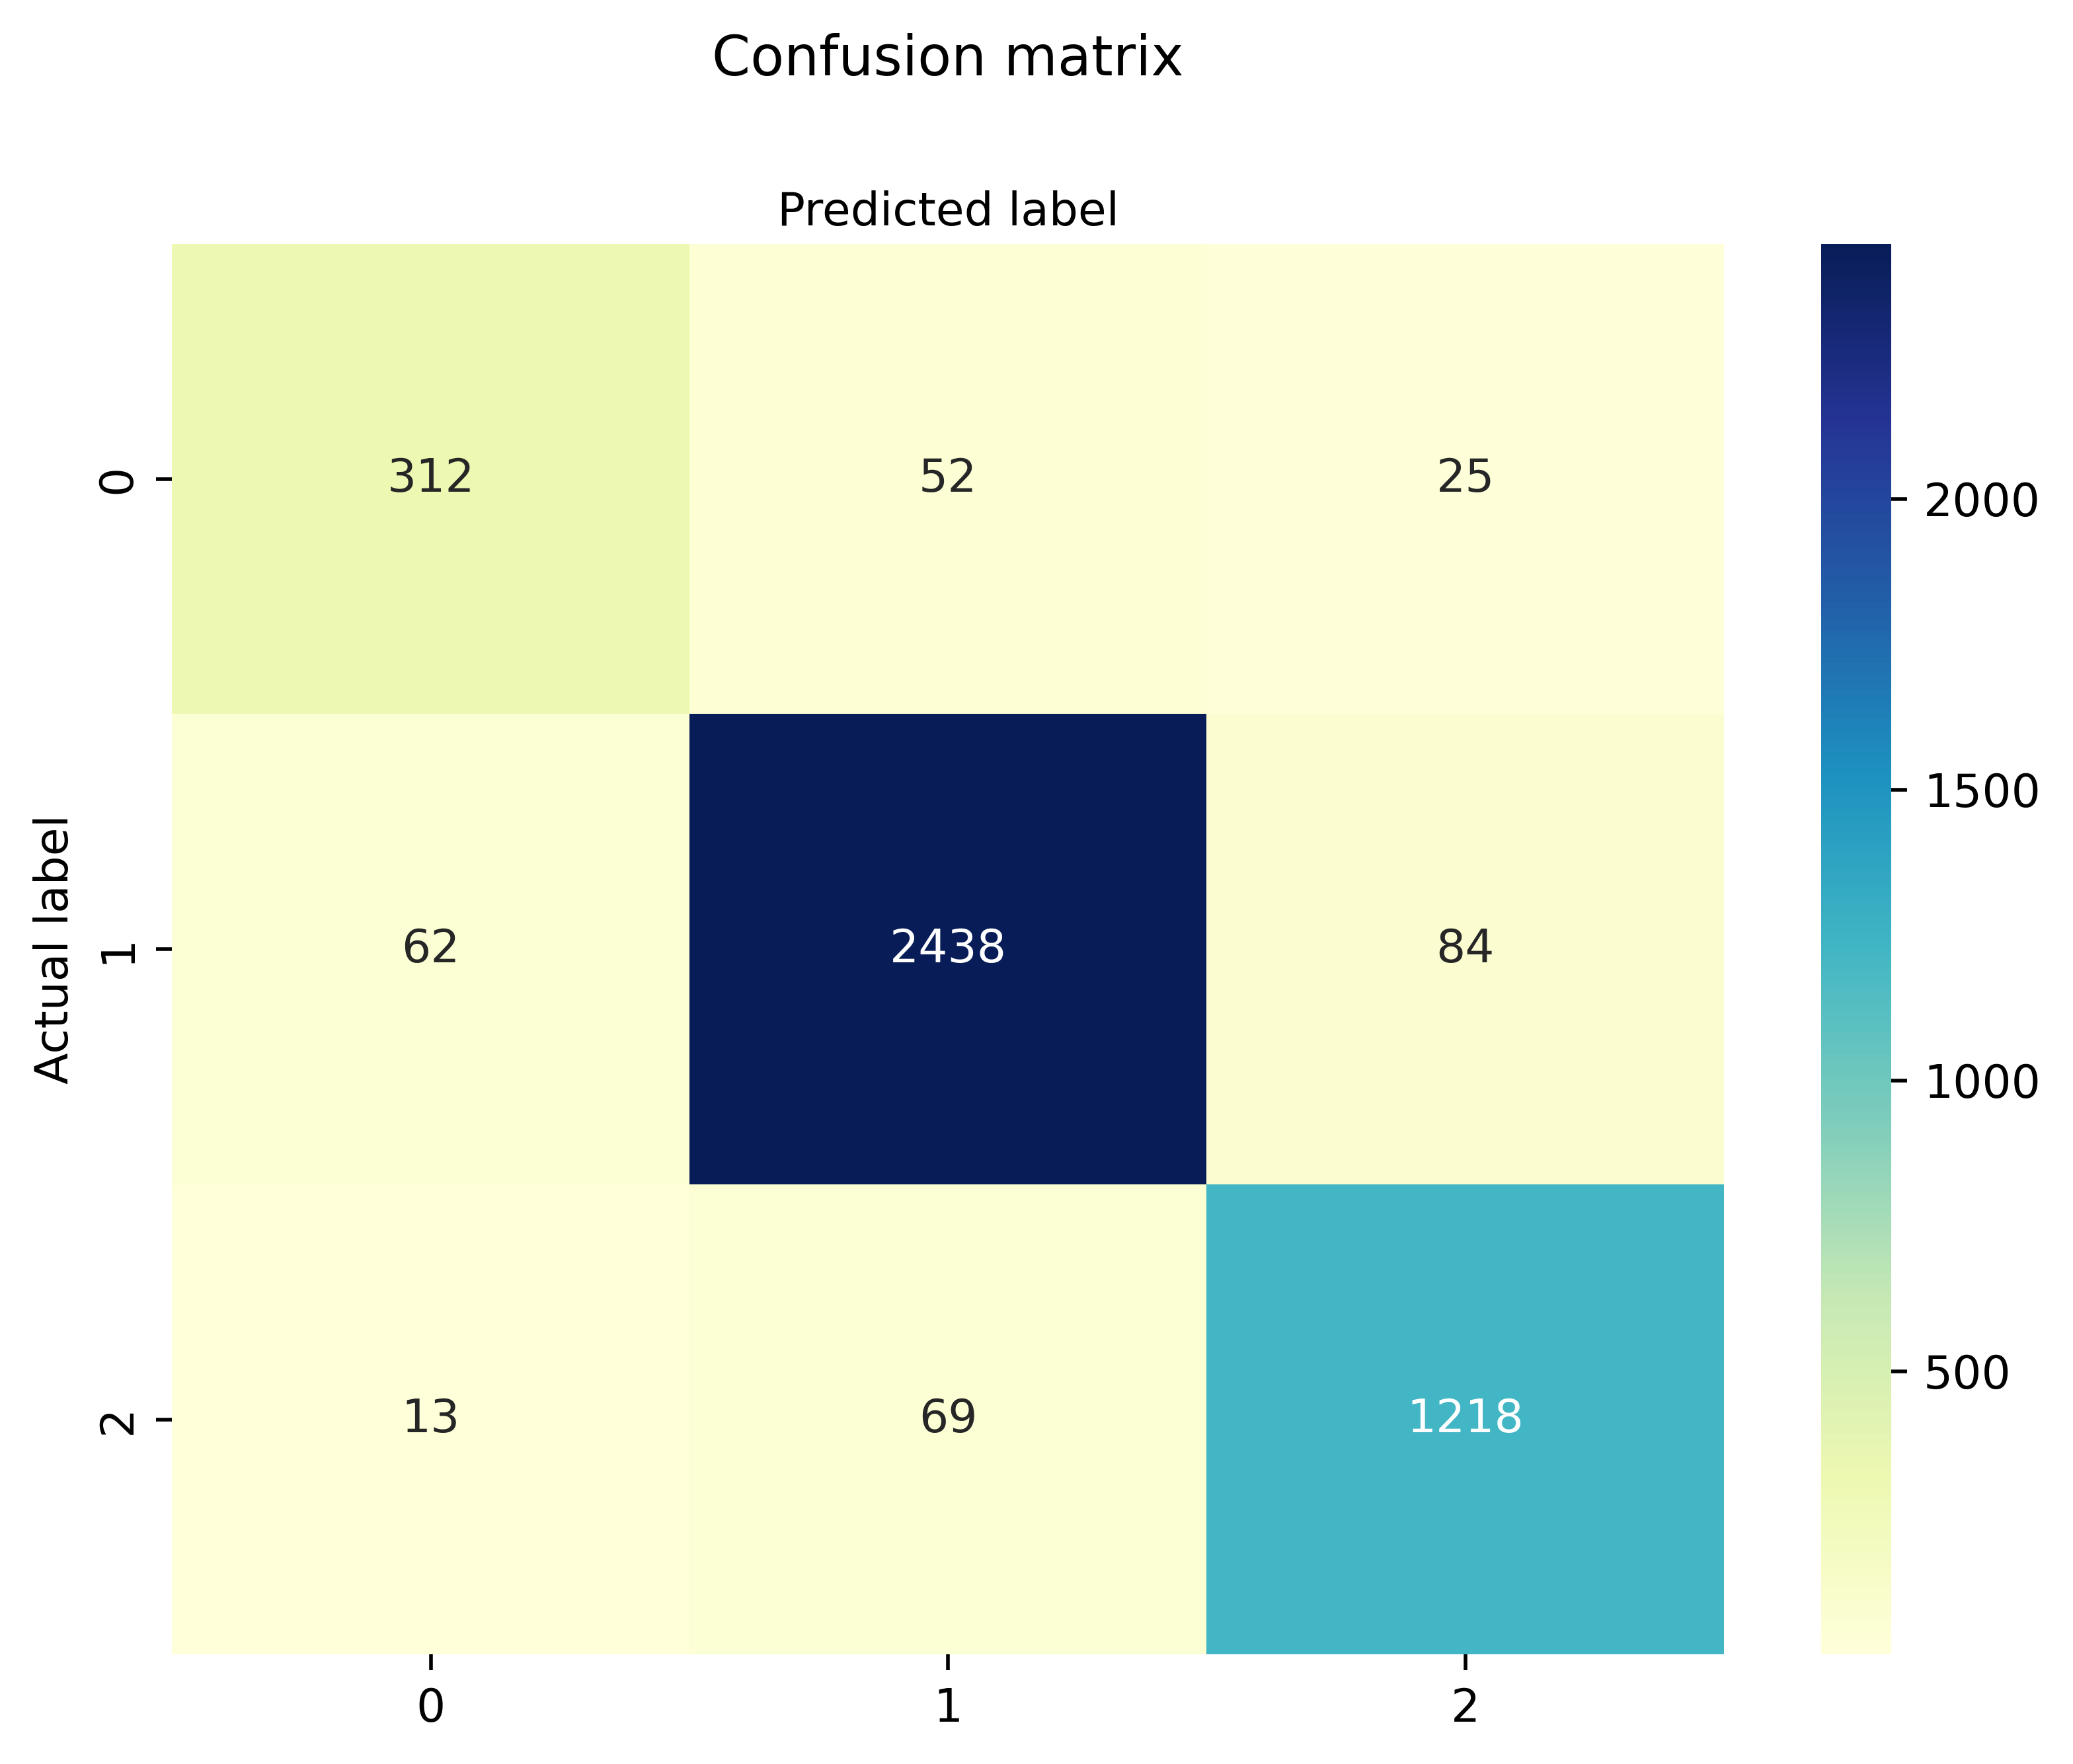

In [45]:
# plotting confusion matrix
plot_conf_mat(cm_tf)

In [46]:
# ROC with one vs rest multiclass
label_binarizer = LabelBinarizer().fit(y_train)
y_onehot_test = label_binarizer.transform(y_test)
y_onehot_test.shape  # (n_samples, n_classes)

(4273, 3)

In [47]:
# changing labels to binary data
label_binarizer.transform([-1])

array([[1, 0, 0]])

In [48]:
# ROC curve showing an individual class
class_of_interest = 0 # neutral sentiment class
class_id = np.flatnonzero(label_binarizer.classes_ == class_of_interest)[0]
y_score = tree_tf.predict_proba(X_test_tfidf_combined)
class_id

1

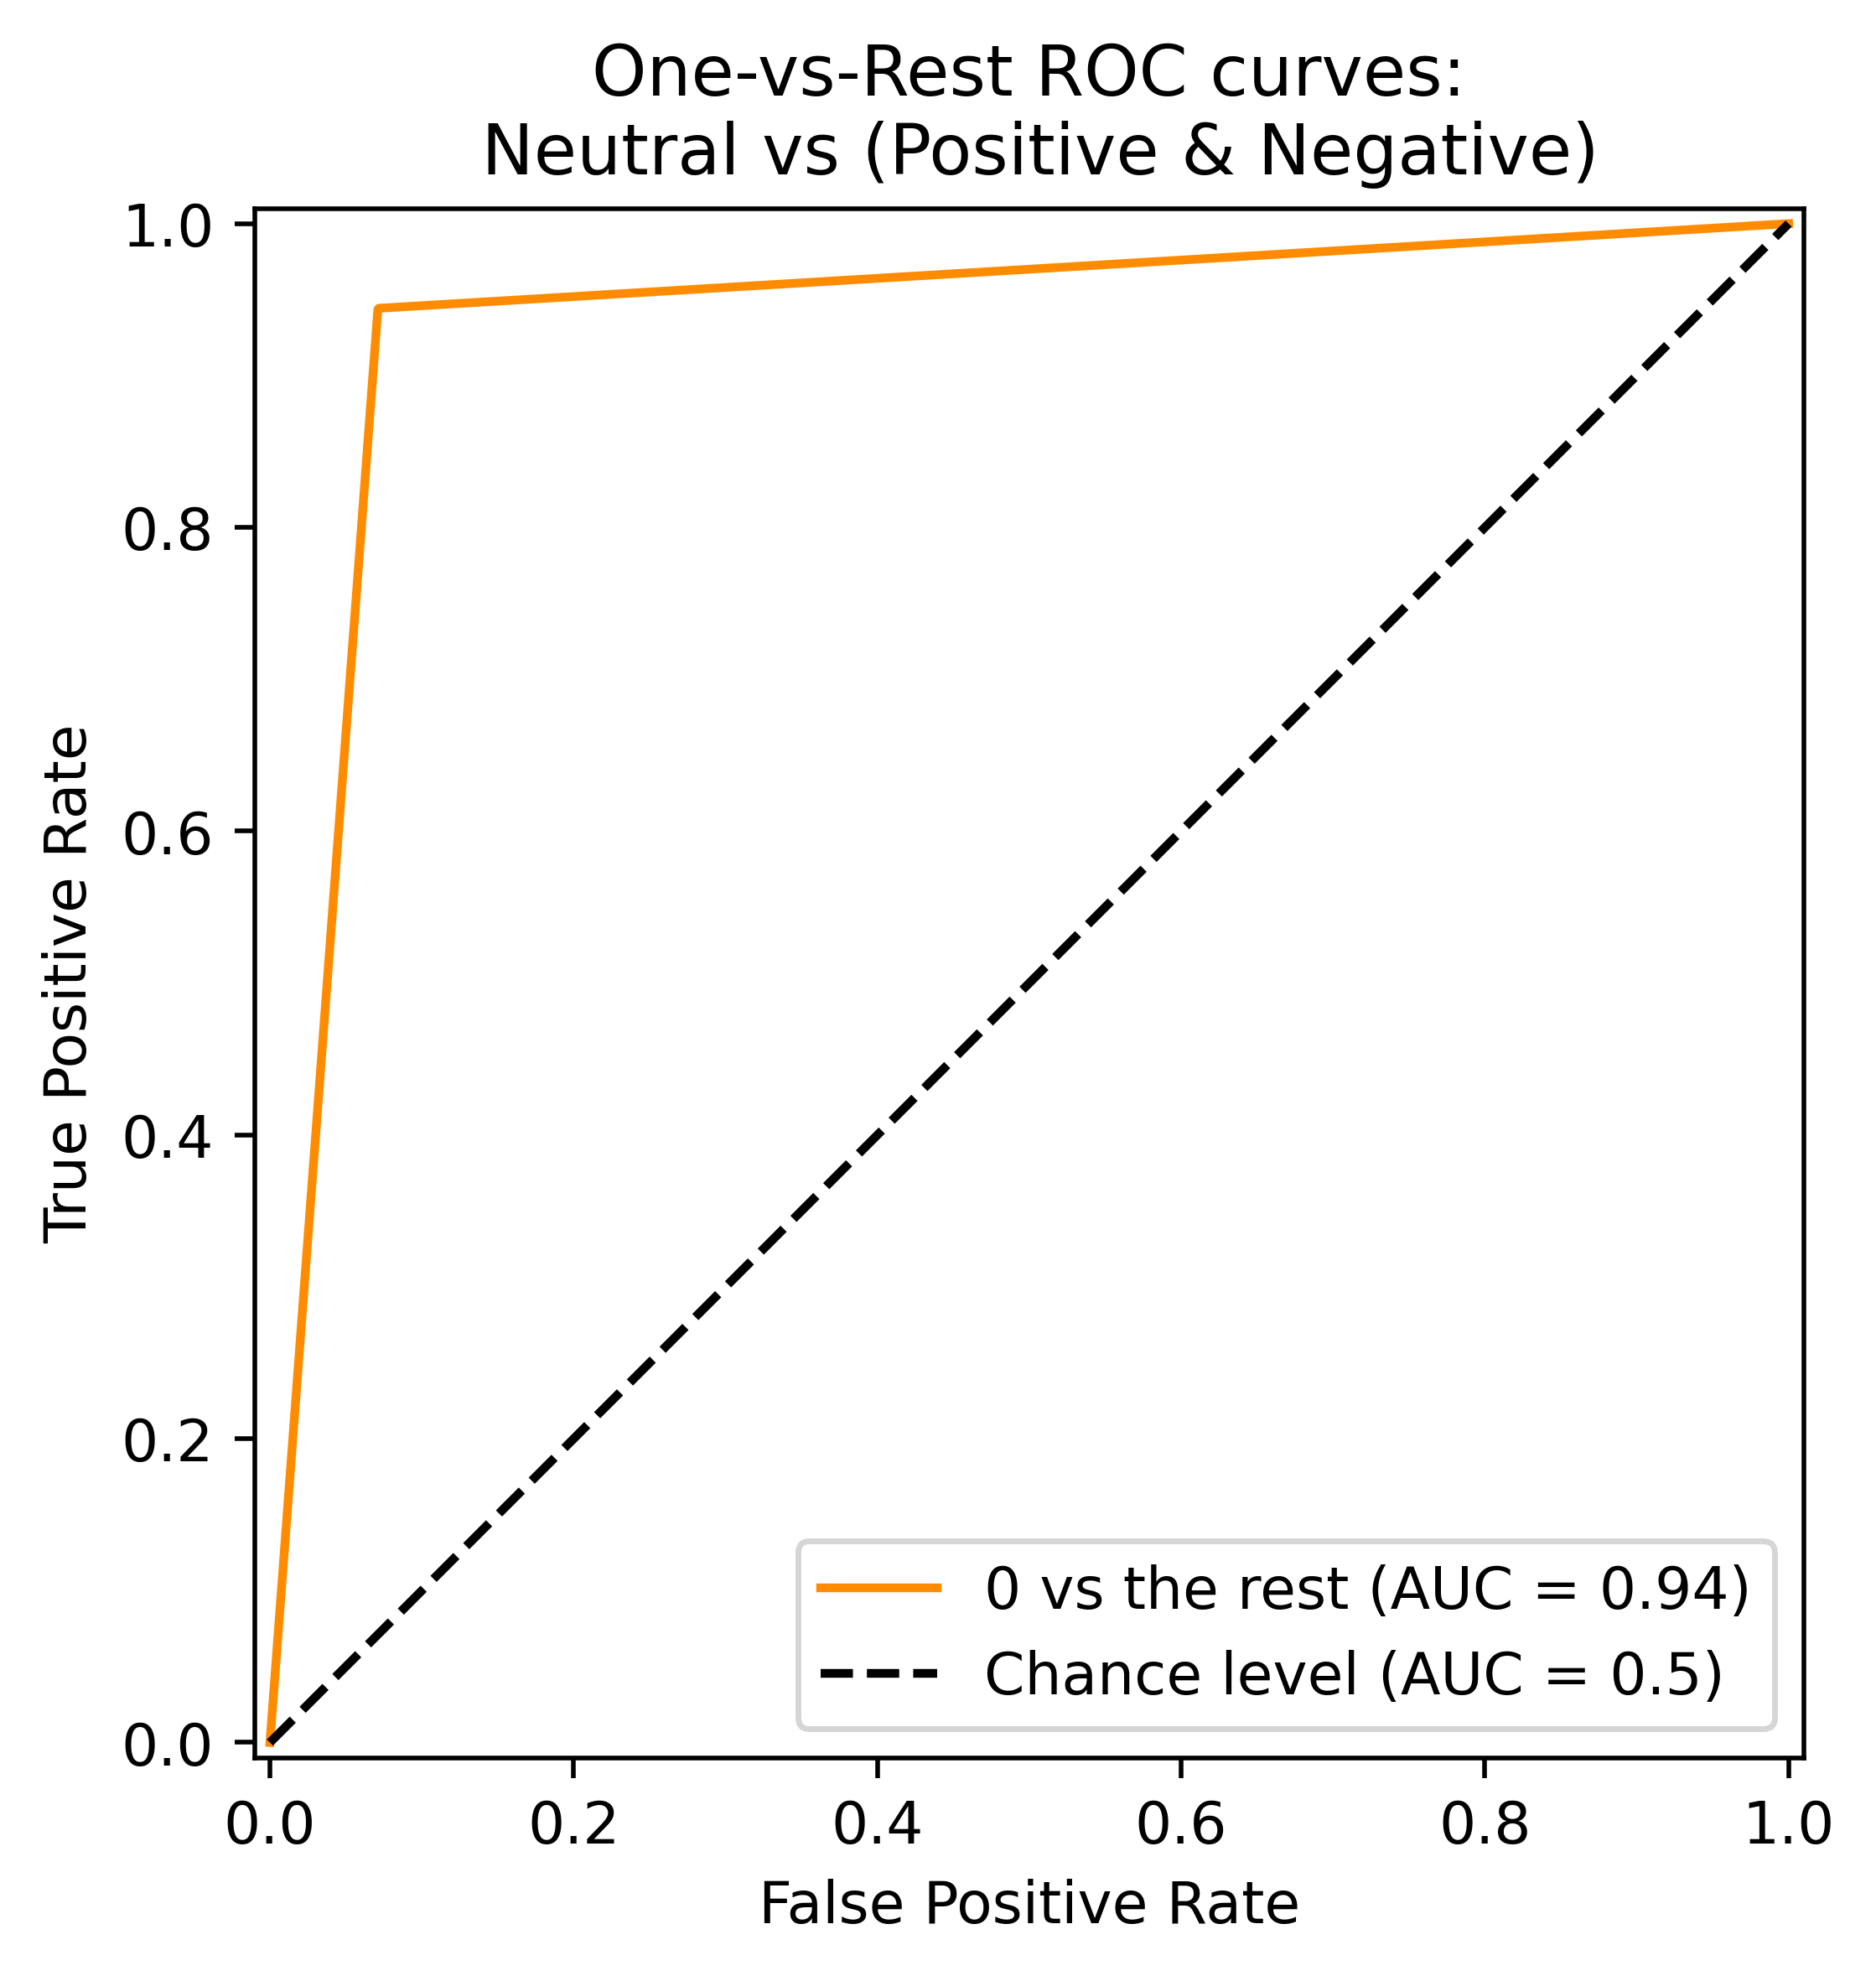

In [49]:
display = RocCurveDisplay.from_predictions(
    y_onehot_test[:, class_id],
    y_score[:, class_id],
    name=f"{class_of_interest} vs the rest",
    color="darkorange",
    plot_chance_level=True,
)
_ = display.ax_.set(
    xlabel="False Positive Rate",
    ylabel="True Positive Rate",
    title="One-vs-Rest ROC curves:\n Neutral vs (Positive & Negative)",
)

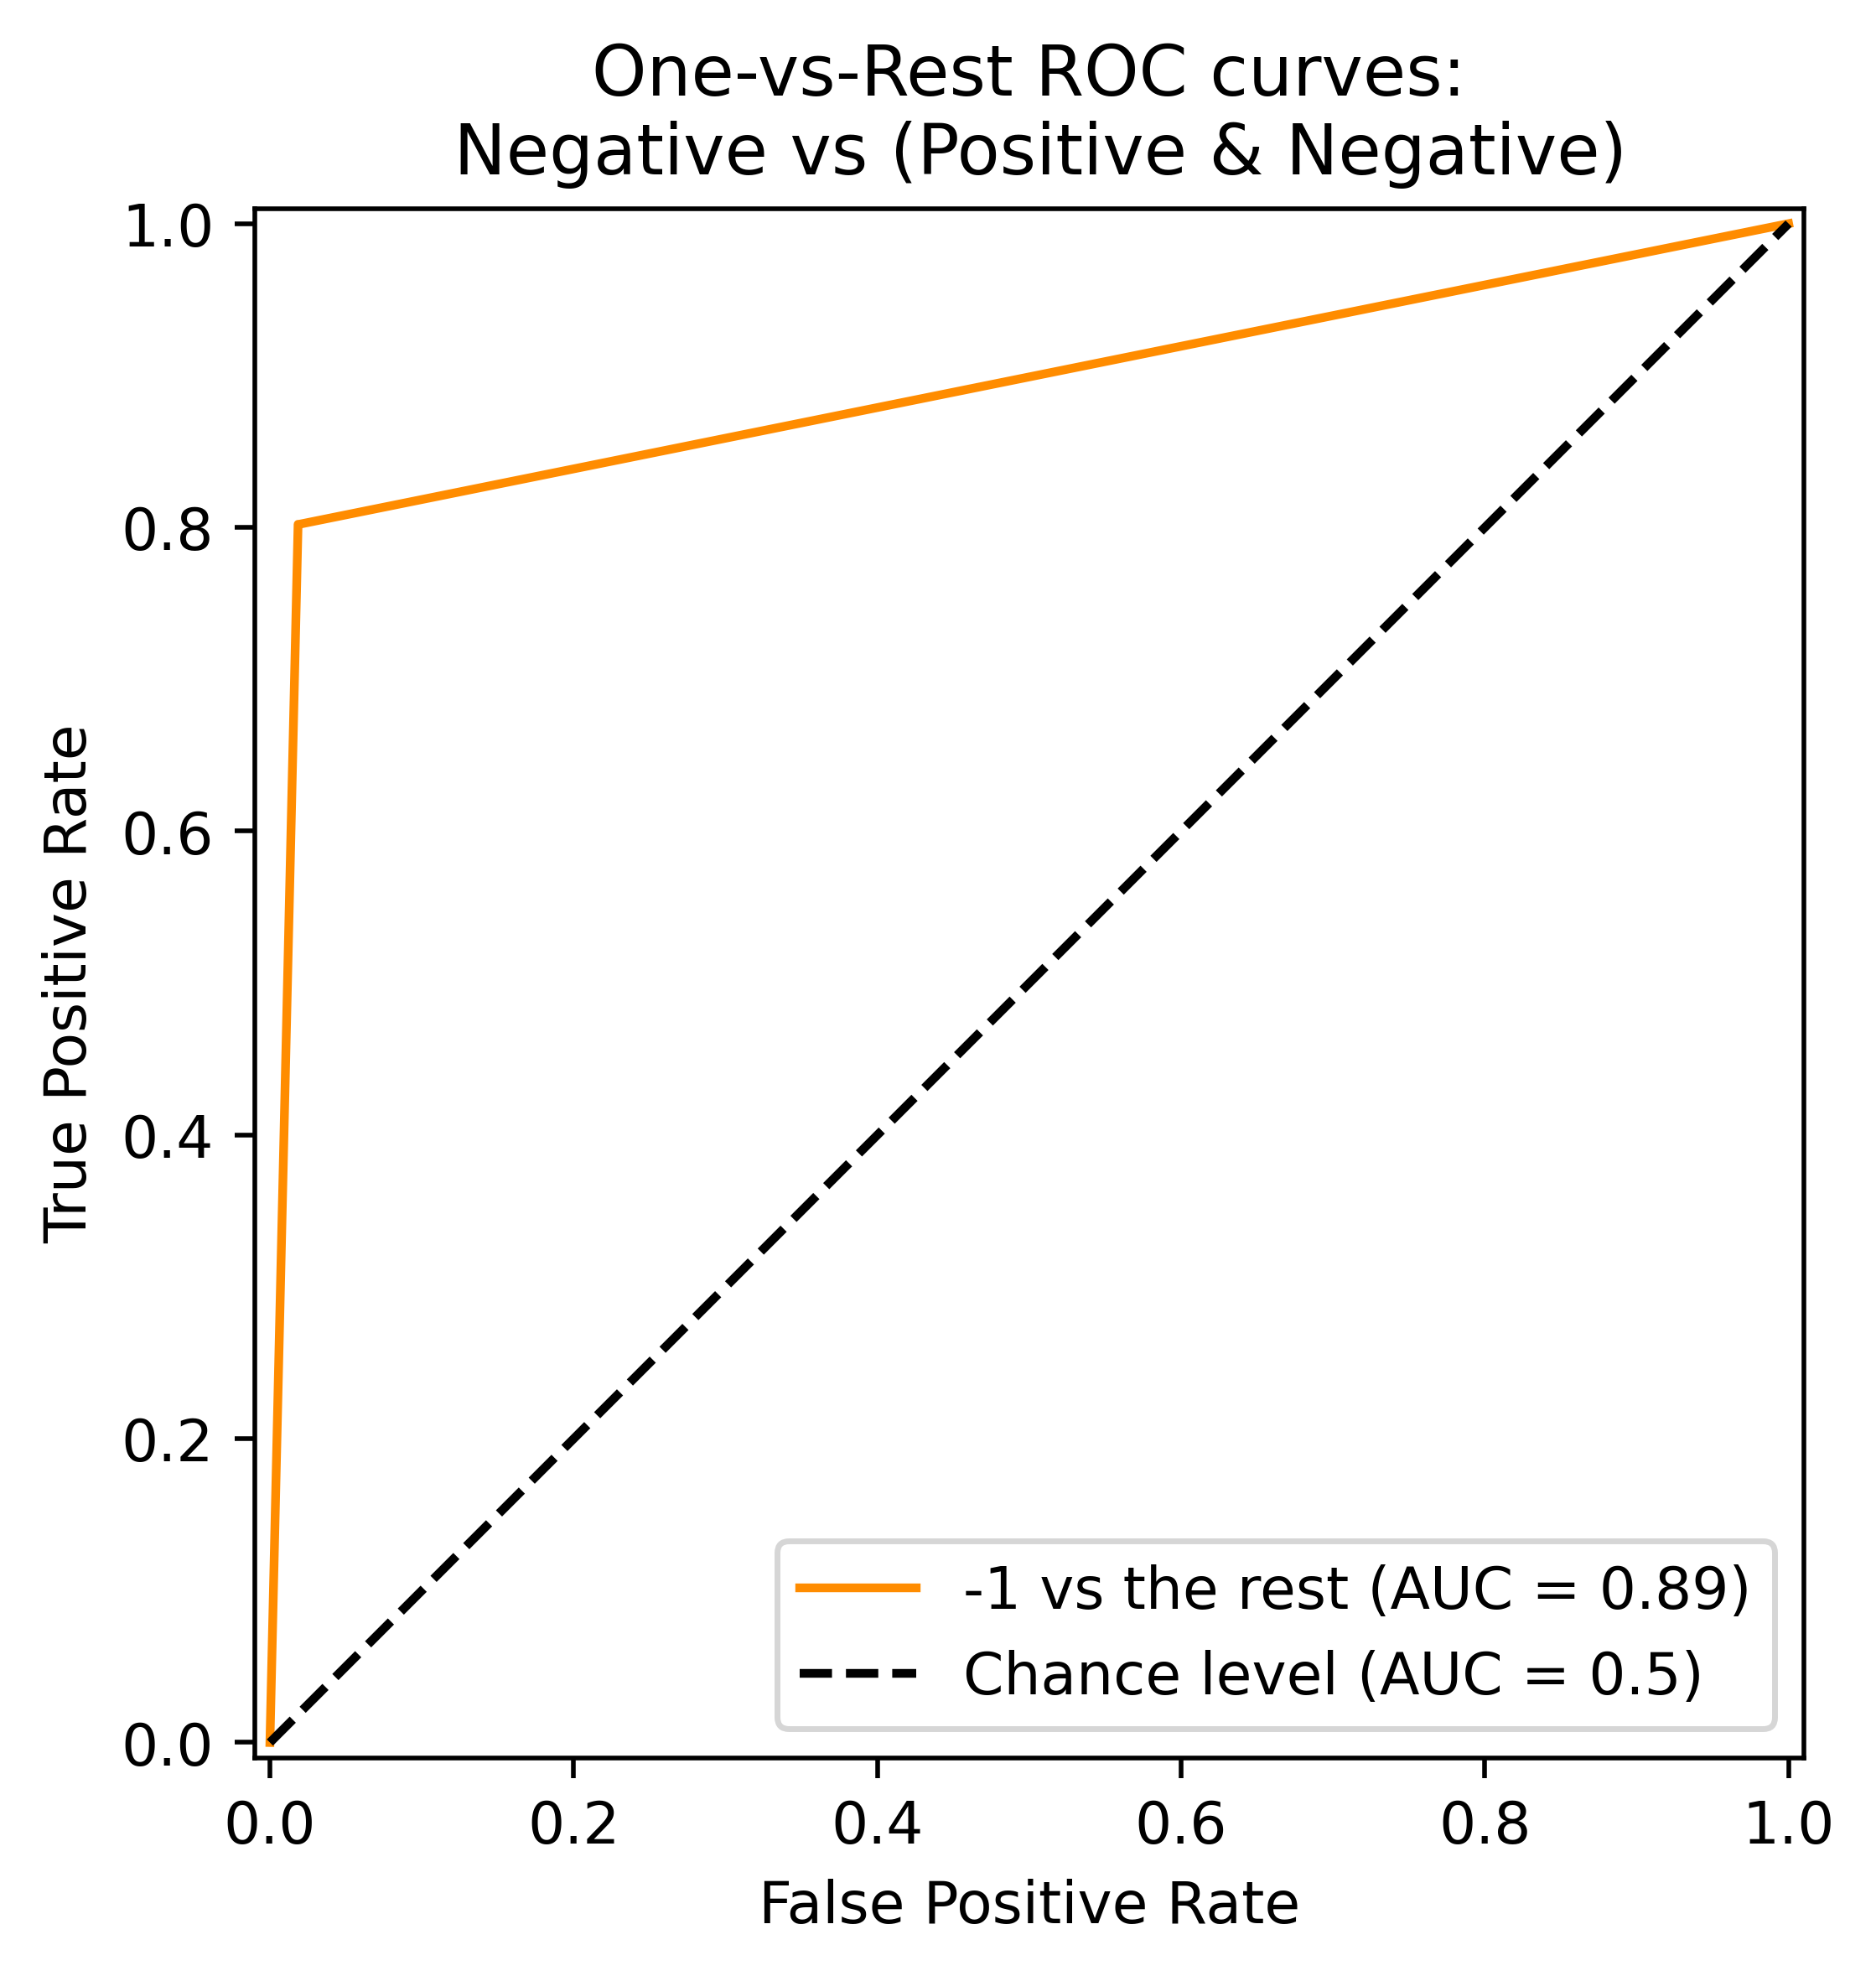

In [50]:
# for negative sentiments
# ROC curve showing an individual class
class_of_interest = -1 # negative sentiment class
class_id = np.flatnonzero(label_binarizer.classes_ == class_of_interest)[0]
display = RocCurveDisplay.from_predictions(
    y_onehot_test[:, class_id],
    y_score[:, class_id],
    name=f"{class_of_interest} vs the rest",
    color="darkorange",
    plot_chance_level=True,
)
_ = display.ax_.set(
    xlabel="False Positive Rate",
    ylabel="True Positive Rate",
    title="One-vs-Rest ROC curves:\n Negative vs (Positive & Negative)",
)

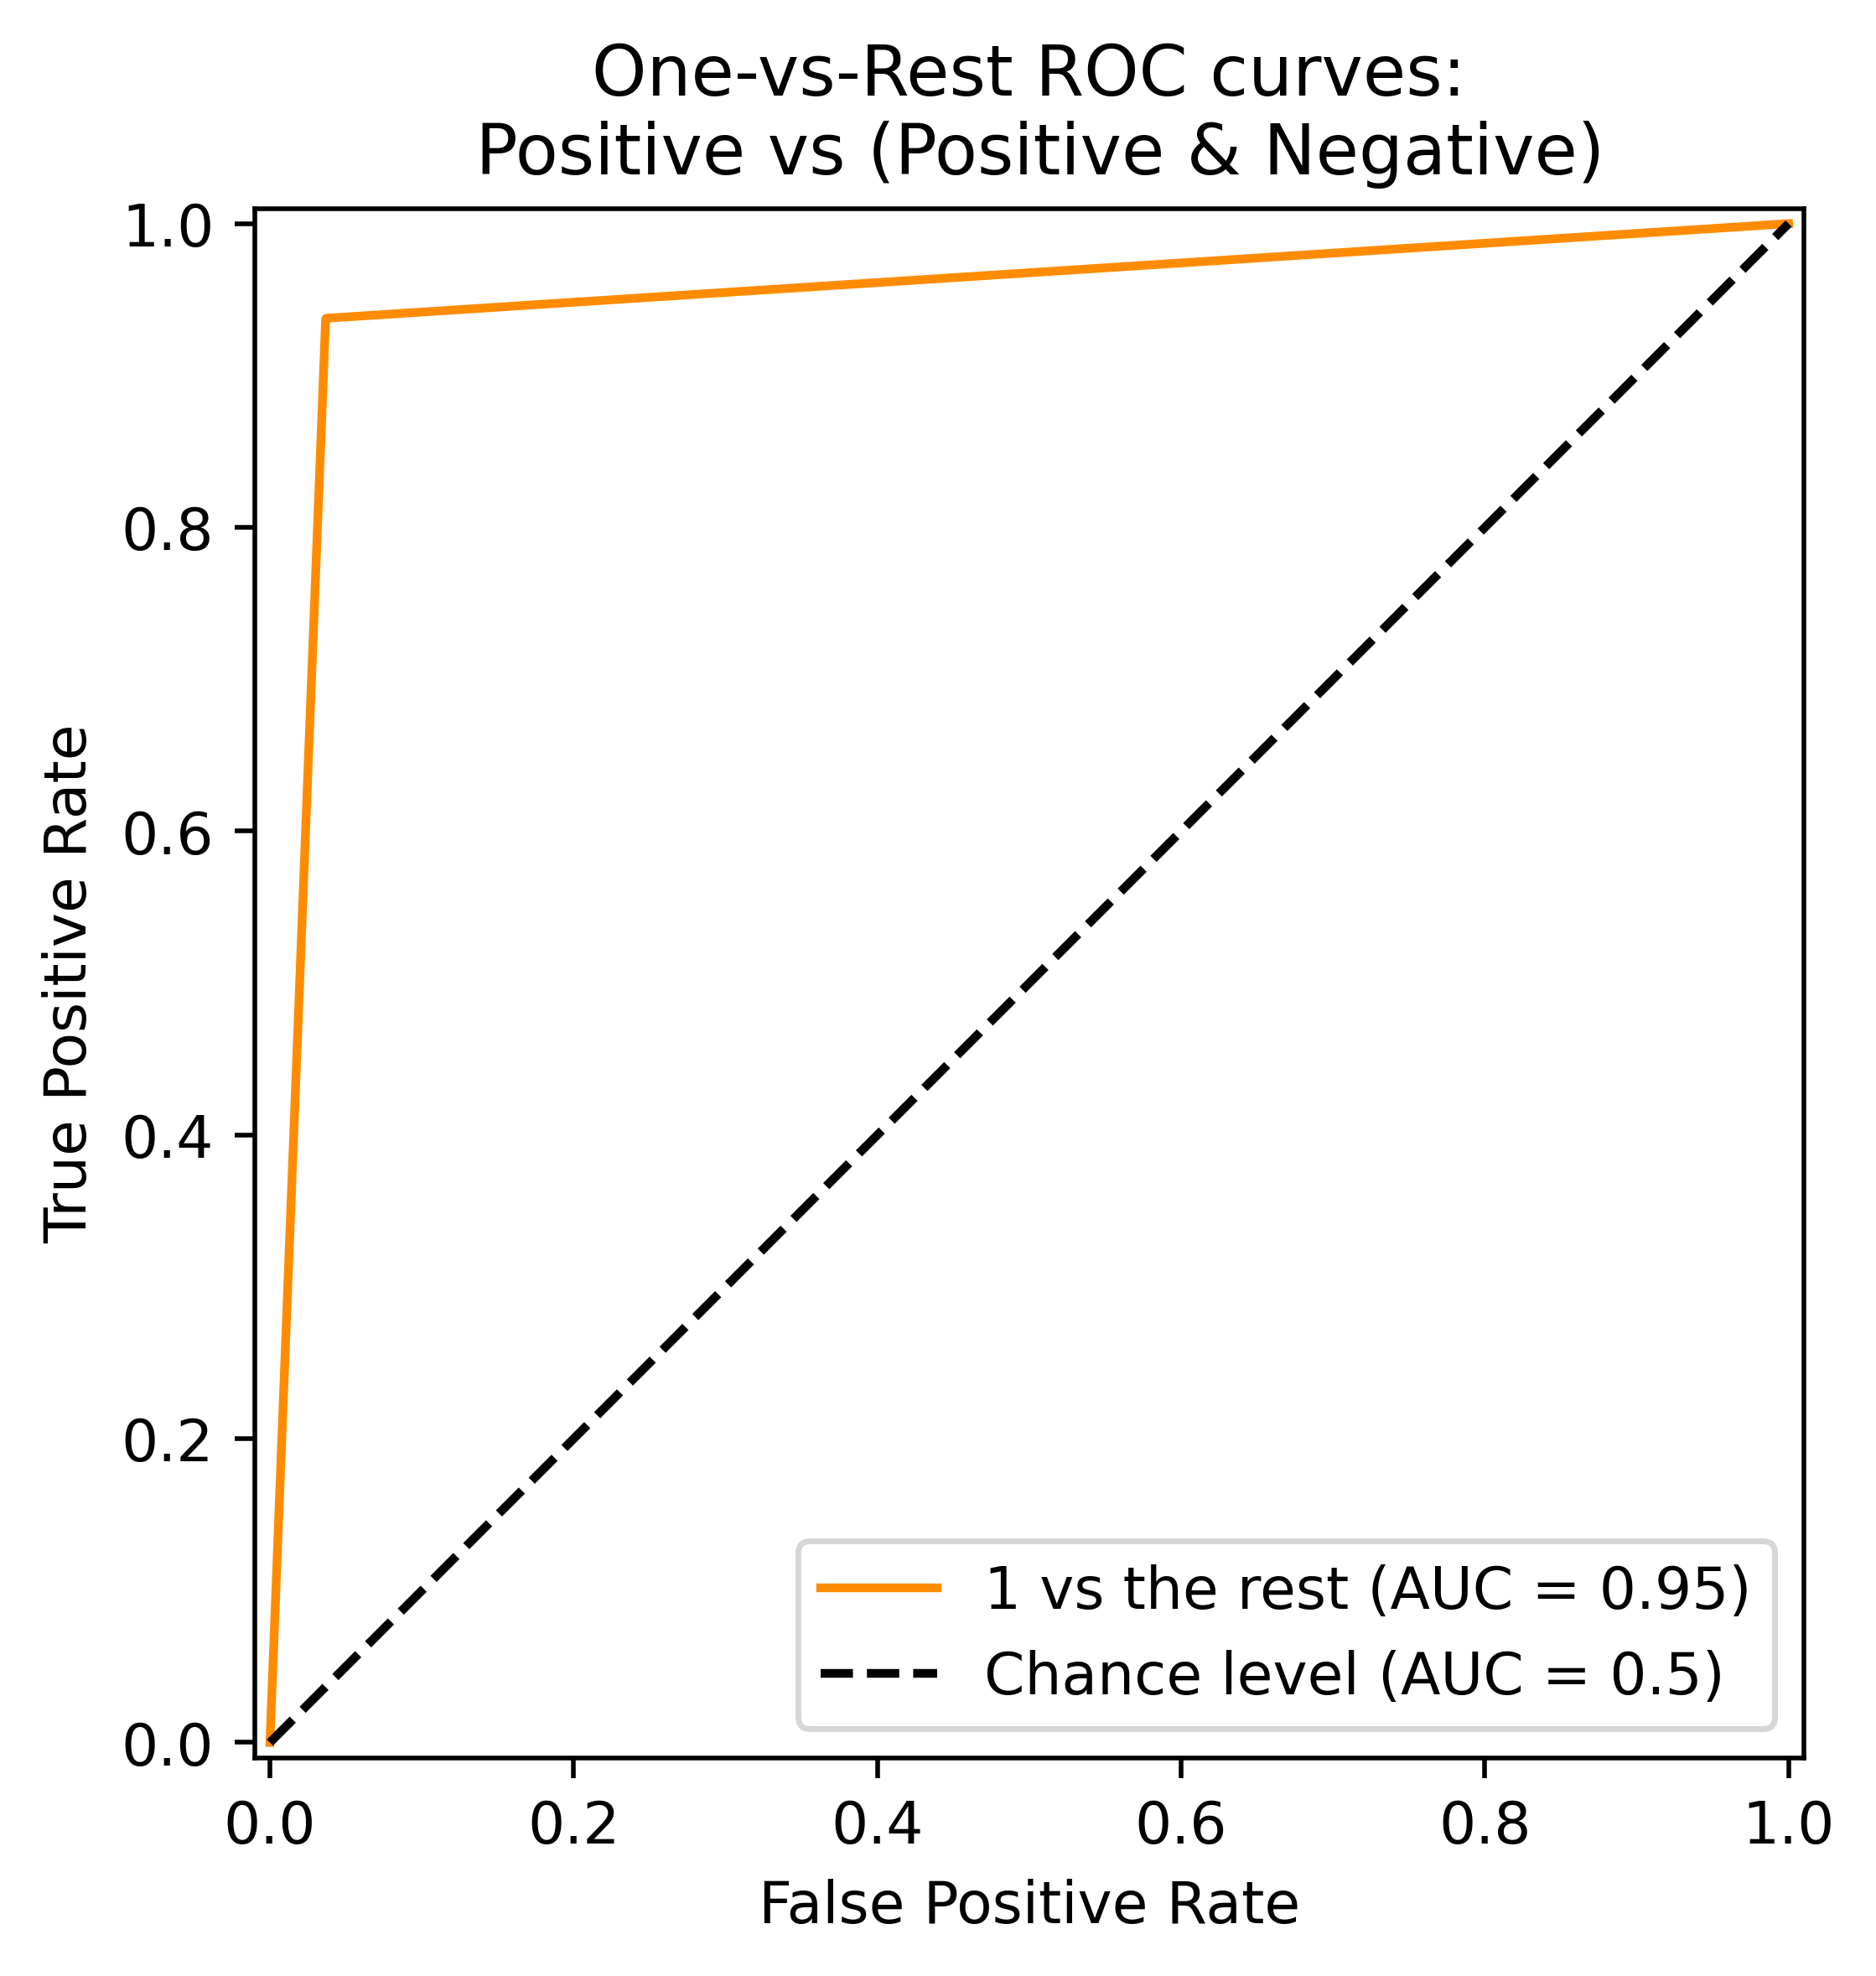

In [51]:
# for positive sentiments
# ROC curve showing an individual class
class_of_interest = 1 # negative sentiment class
class_id = np.flatnonzero(label_binarizer.classes_ == class_of_interest)[0]
display = RocCurveDisplay.from_predictions(
    y_onehot_test[:, class_id],
    y_score[:, class_id],
    name=f"{class_of_interest} vs the rest",
    color="darkorange",
    plot_chance_level=True,
)
_ = display.ax_.set(
    xlabel="False Positive Rate",
    ylabel="True Positive Rate",
    title="One-vs-Rest ROC curves:\n Positive vs (Positive & Negative)",
)

## Roc Micro Averaged for TFIDF
##### Micro-averaging aggregates the contributions from all the classes (using numpy.ravel) to compute the average metrics. In a multi-class classification setup with highly imbalanced classes, micro-averaging is preferred.

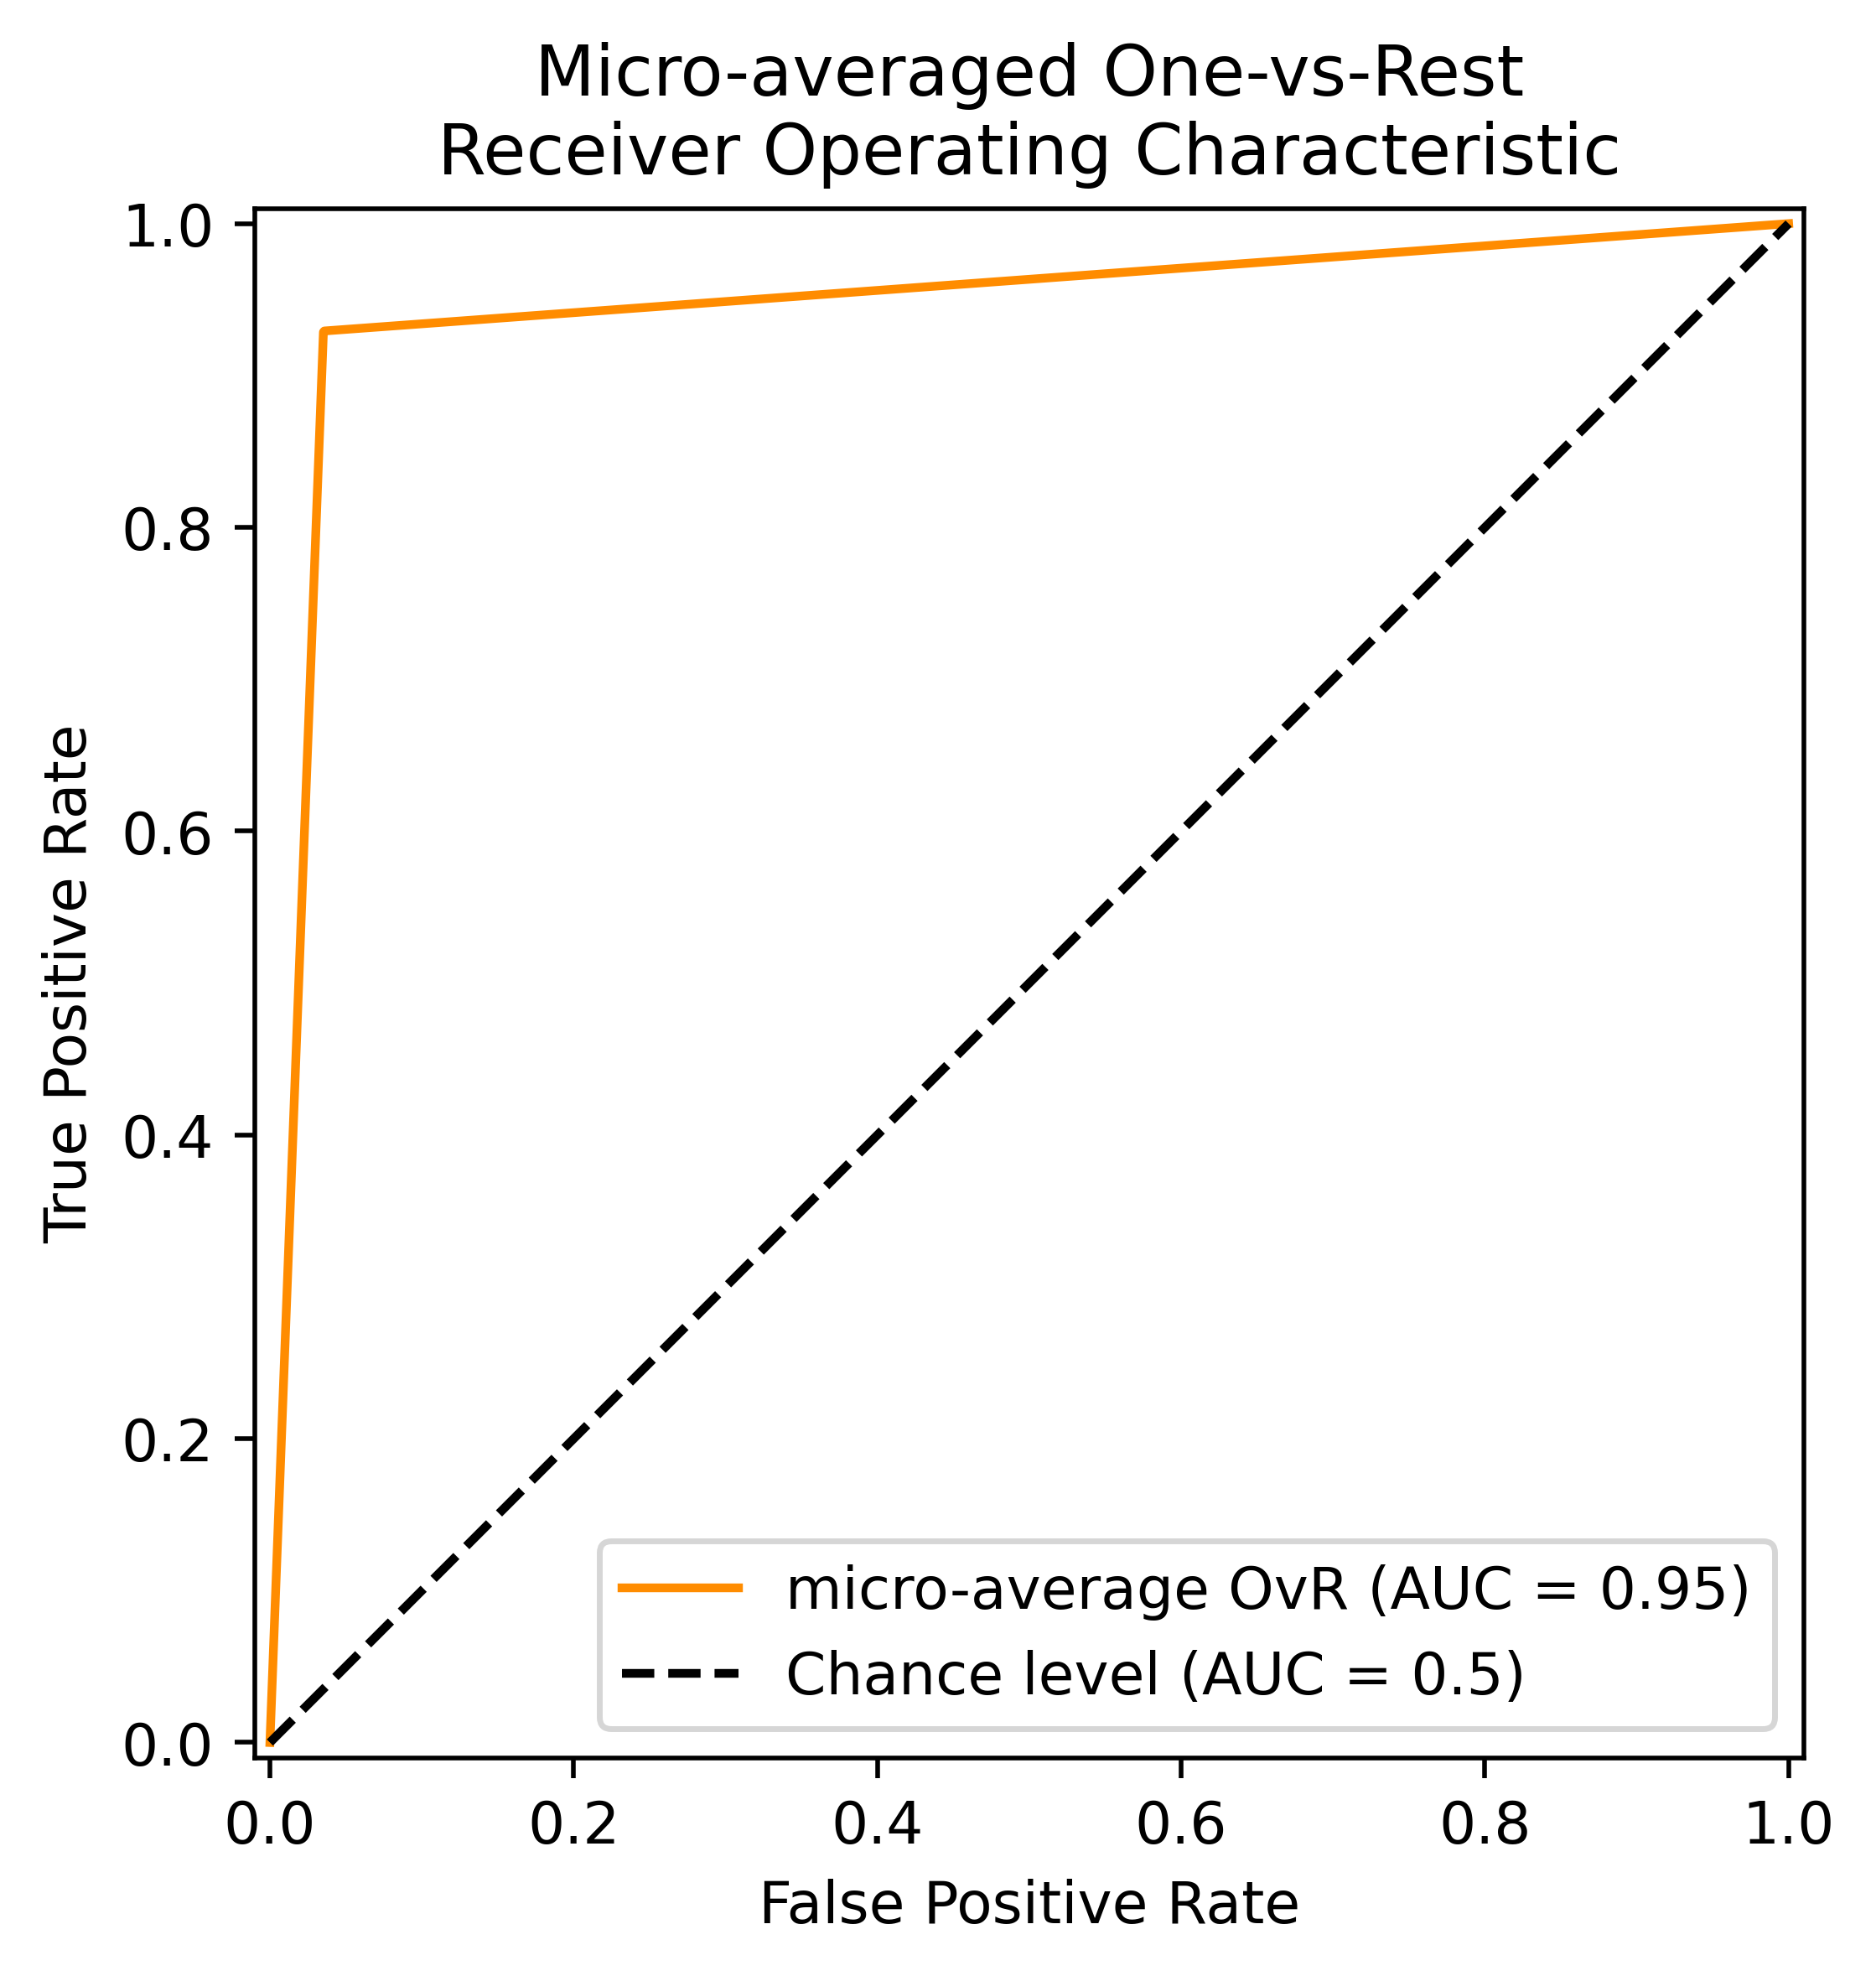

In [52]:
display = RocCurveDisplay.from_predictions(
    y_onehot_test.ravel(),
    y_score.ravel(),
    name="micro-average OvR",
    color="darkorange",
    plot_chance_level=True,
)
_ = display.ax_.set(
    xlabel="False Positive Rate",
    ylabel="True Positive Rate",
    title="Micro-averaged One-vs-Rest\nReceiver Operating Characteristic",
)

In [53]:
# computing ROC-AUC score
micro_roc_auc_ovr = roc_auc_score(
    y_test,
    y_score,
    multi_class="ovr",
    average="micro",
)
print(f"Micro-averaged One-vs-Rest ROC AUC score:\n{micro_roc_auc_ovr}")

Micro-averaged One-vs-Rest ROC AUC score:
0.9470180073104465


## Bag of word Vectorizer

In [54]:
# Creating BoW vectorizer for text
bow_vectorizer_text = CountVectorizer(max_features=1000)

# Fitting and transforming the text training set
X_train_bow_text = bow_vectorizer_text.fit_transform(X_train['text'])
X_test_bow_text = bow_vectorizer_text.transform(X_test['text'])
bow_vectorizer_url = CountVectorizer(max_features=1000)

# Fitting and transforming the url training set
X_train_bow_url = bow_vectorizer_url.fit_transform(X_train['base_url'])
X_test_bow_url = bow_vectorizer_url.transform(X_test['base_url'])
X_train_bow_company_name = bow_vectorizer_url.fit_transform(X_train['company_names'])
X_test_bow_company_name = bow_vectorizer_url.transform(X_test['company_names'])
X_train_bow_combined = hstack([X_train_bow_text, X_train_bow_url, X_train_bow_company_name])
X_test_bow_combined = hstack([X_test_bow_text, X_test_bow_url, X_test_bow_company_name])


In [55]:
# Creating and training the tree model
tree_model = tree.DecisionTreeClassifier()
tree_model.fit(X_train_bow_combined, y_train)

# Predicting on the test set
y_pred = tree_model.predict(X_test_bow_combined)

# Evaluating the model
accuracy = accuracy_score(y_test, y_pred)
print(f"Accuracy: {accuracy}")

# Classification report
print(classification_report(y_test, y_pred))

Accuracy: 0.9363444886496607
              precision    recall  f1-score   support

          -1       0.84      0.81      0.83       389
           0       0.96      0.95      0.95      2584
           1       0.92      0.94      0.93      1300

    accuracy                           0.94      4273
   macro avg       0.91      0.90      0.90      4273
weighted avg       0.94      0.94      0.94      4273



## Tunning Tree hyper parameters

In [56]:
# confusion matrix
cm_bow = confusion_matrix(y_test, y_pred)
cm_bow

array([[ 317,   51,   21],
       [  48, 2457,   79],
       [  14,   59, 1227]])

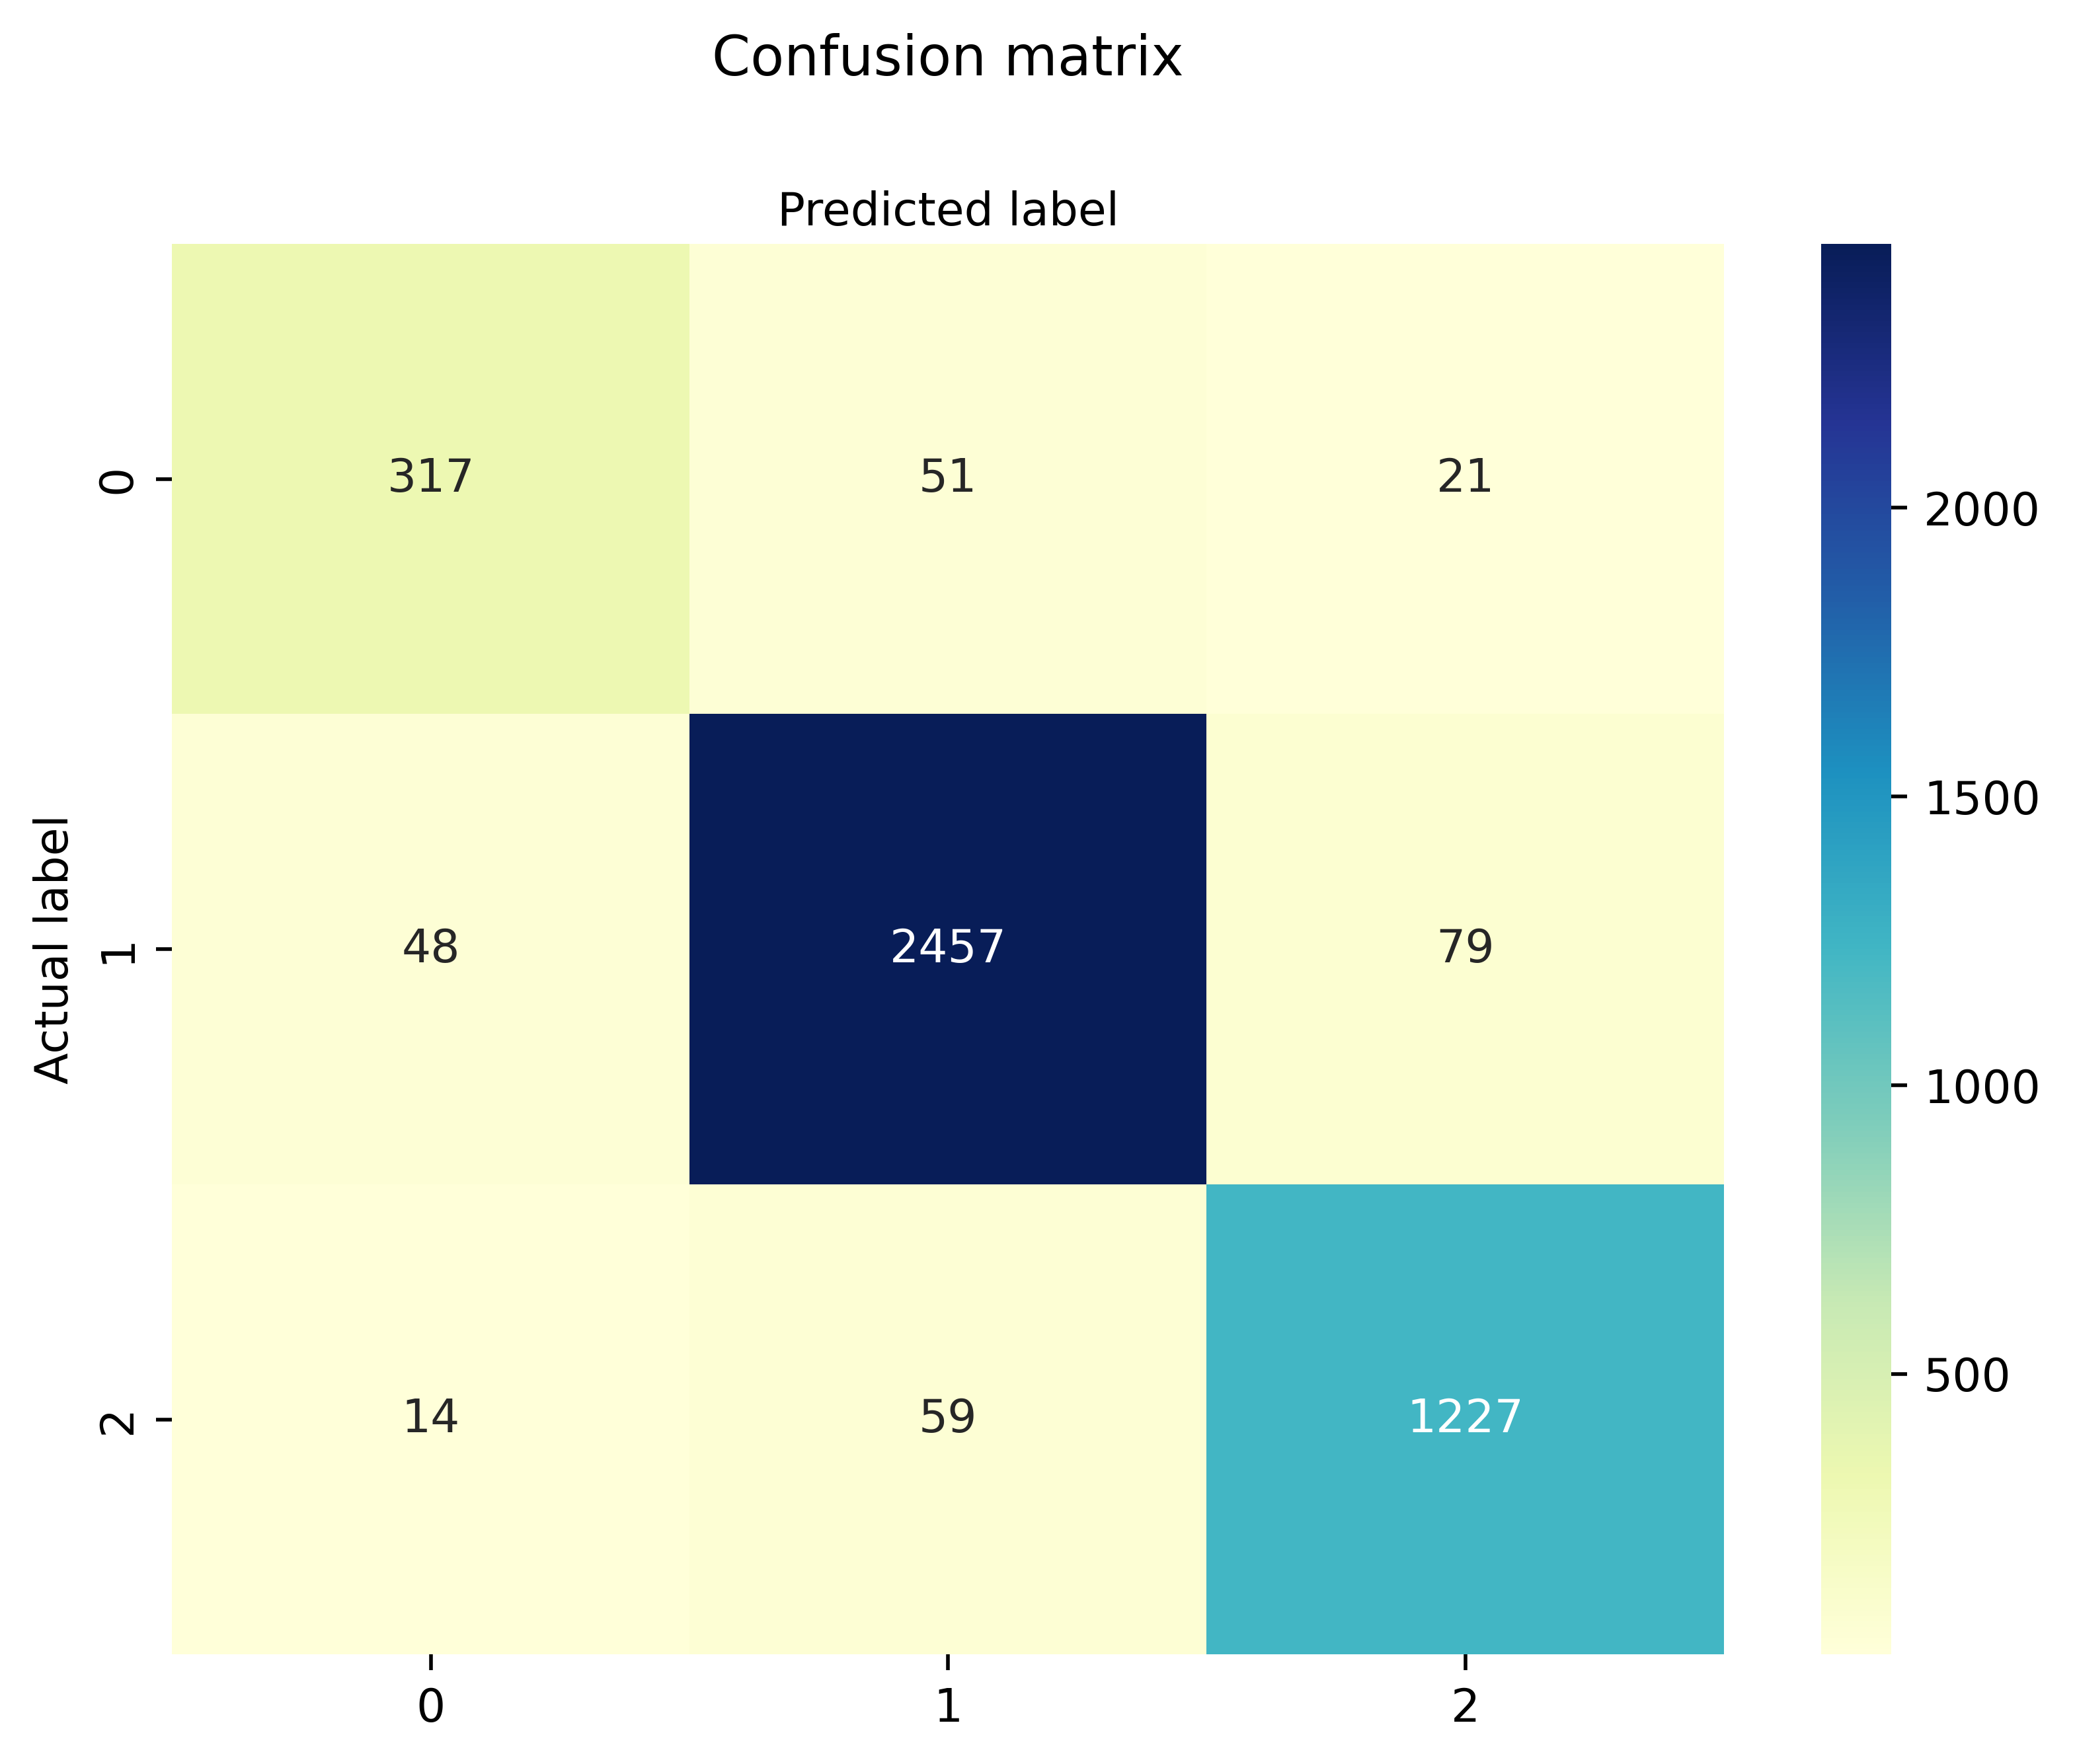

In [57]:
# plotting confusion matrix
plot_conf_mat(cm_bow)

In [58]:
# ROC with one vs rest multiclass
label_binarizer = LabelBinarizer().fit(y_train)
y_onehot_test = label_binarizer.transform(y_test)
y_onehot_test.shape  # (n_samples, n_classes)

(4273, 3)

In [59]:
label_binarizer.transform([-1])

array([[1, 0, 0]])

In [60]:
# ROC curve showing an individual class
class_of_interest = 0 # neutral sentiment class
class_id = np.flatnonzero(label_binarizer.classes_ == class_of_interest)[0]
y_score = tree_model.predict_proba(X_test_bow_combined)
class_id

1

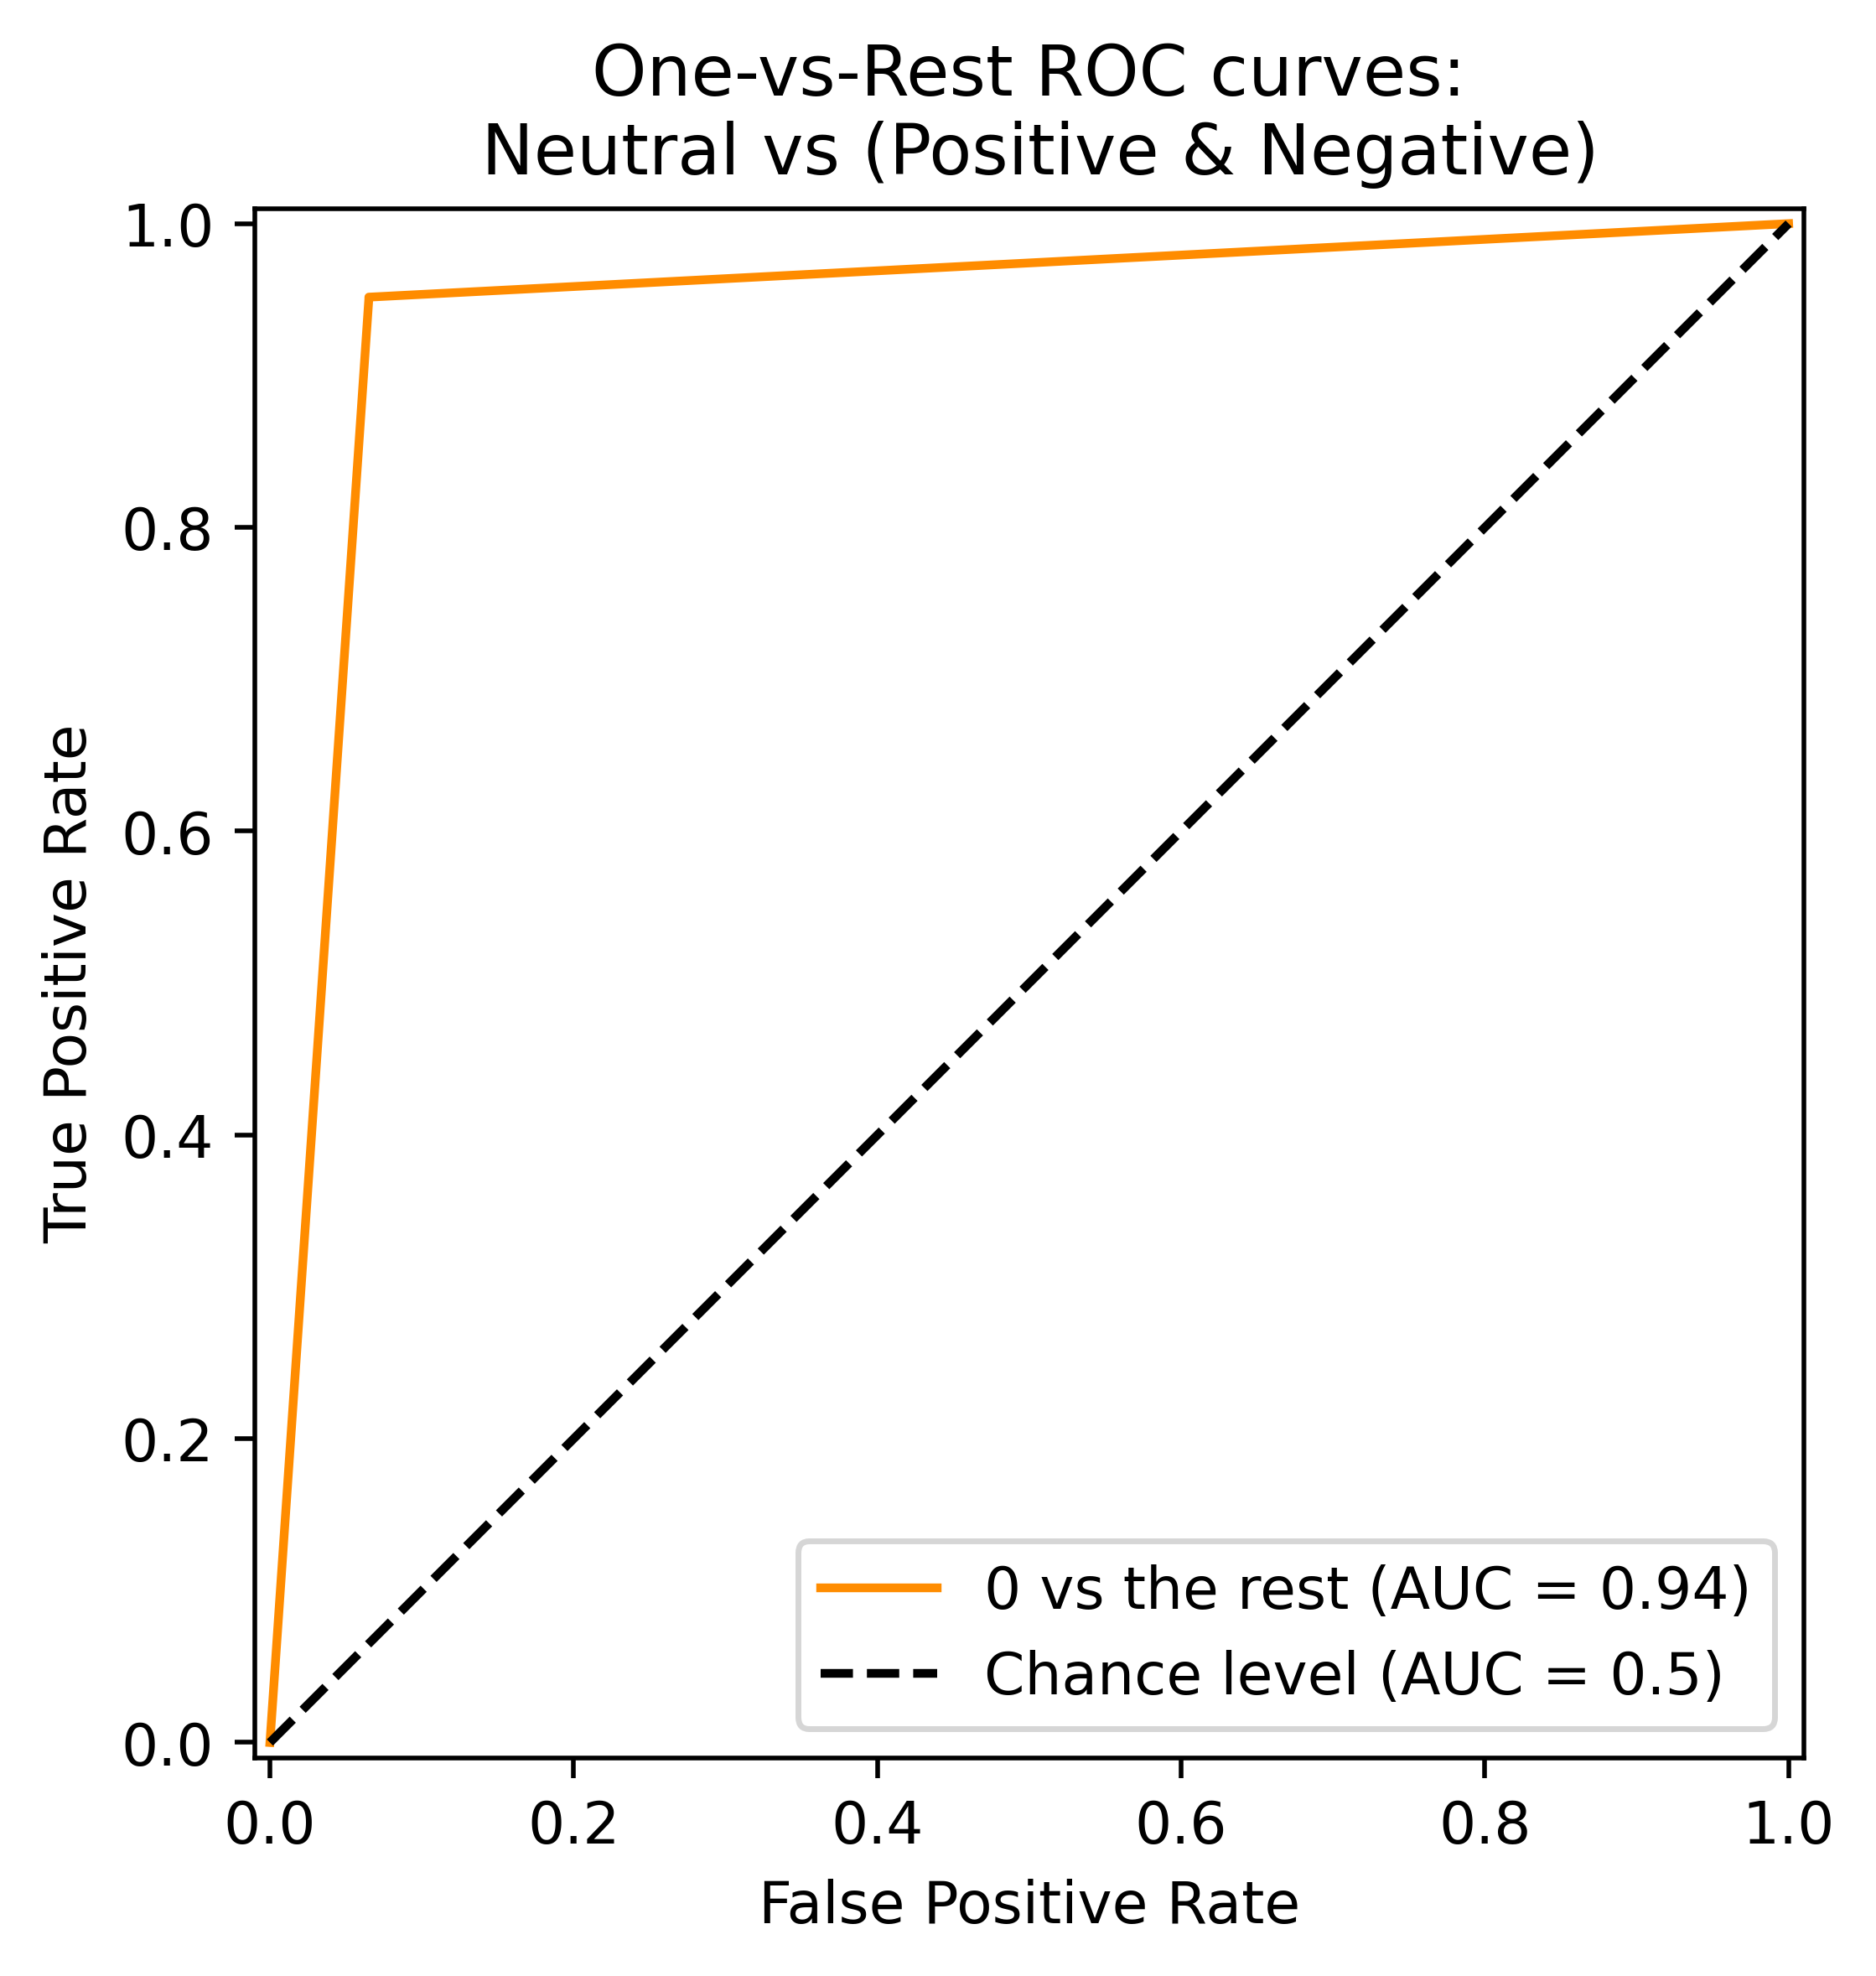

In [61]:
display = RocCurveDisplay.from_predictions(
    y_onehot_test[:, class_id],
    y_score[:, class_id],
    name=f"{class_of_interest} vs the rest",
    color="darkorange",
    plot_chance_level=True,
)
_ = display.ax_.set(
    xlabel="False Positive Rate",
    ylabel="True Positive Rate",
    title="One-vs-Rest ROC curves:\n Neutral vs (Positive & Negative)",
)

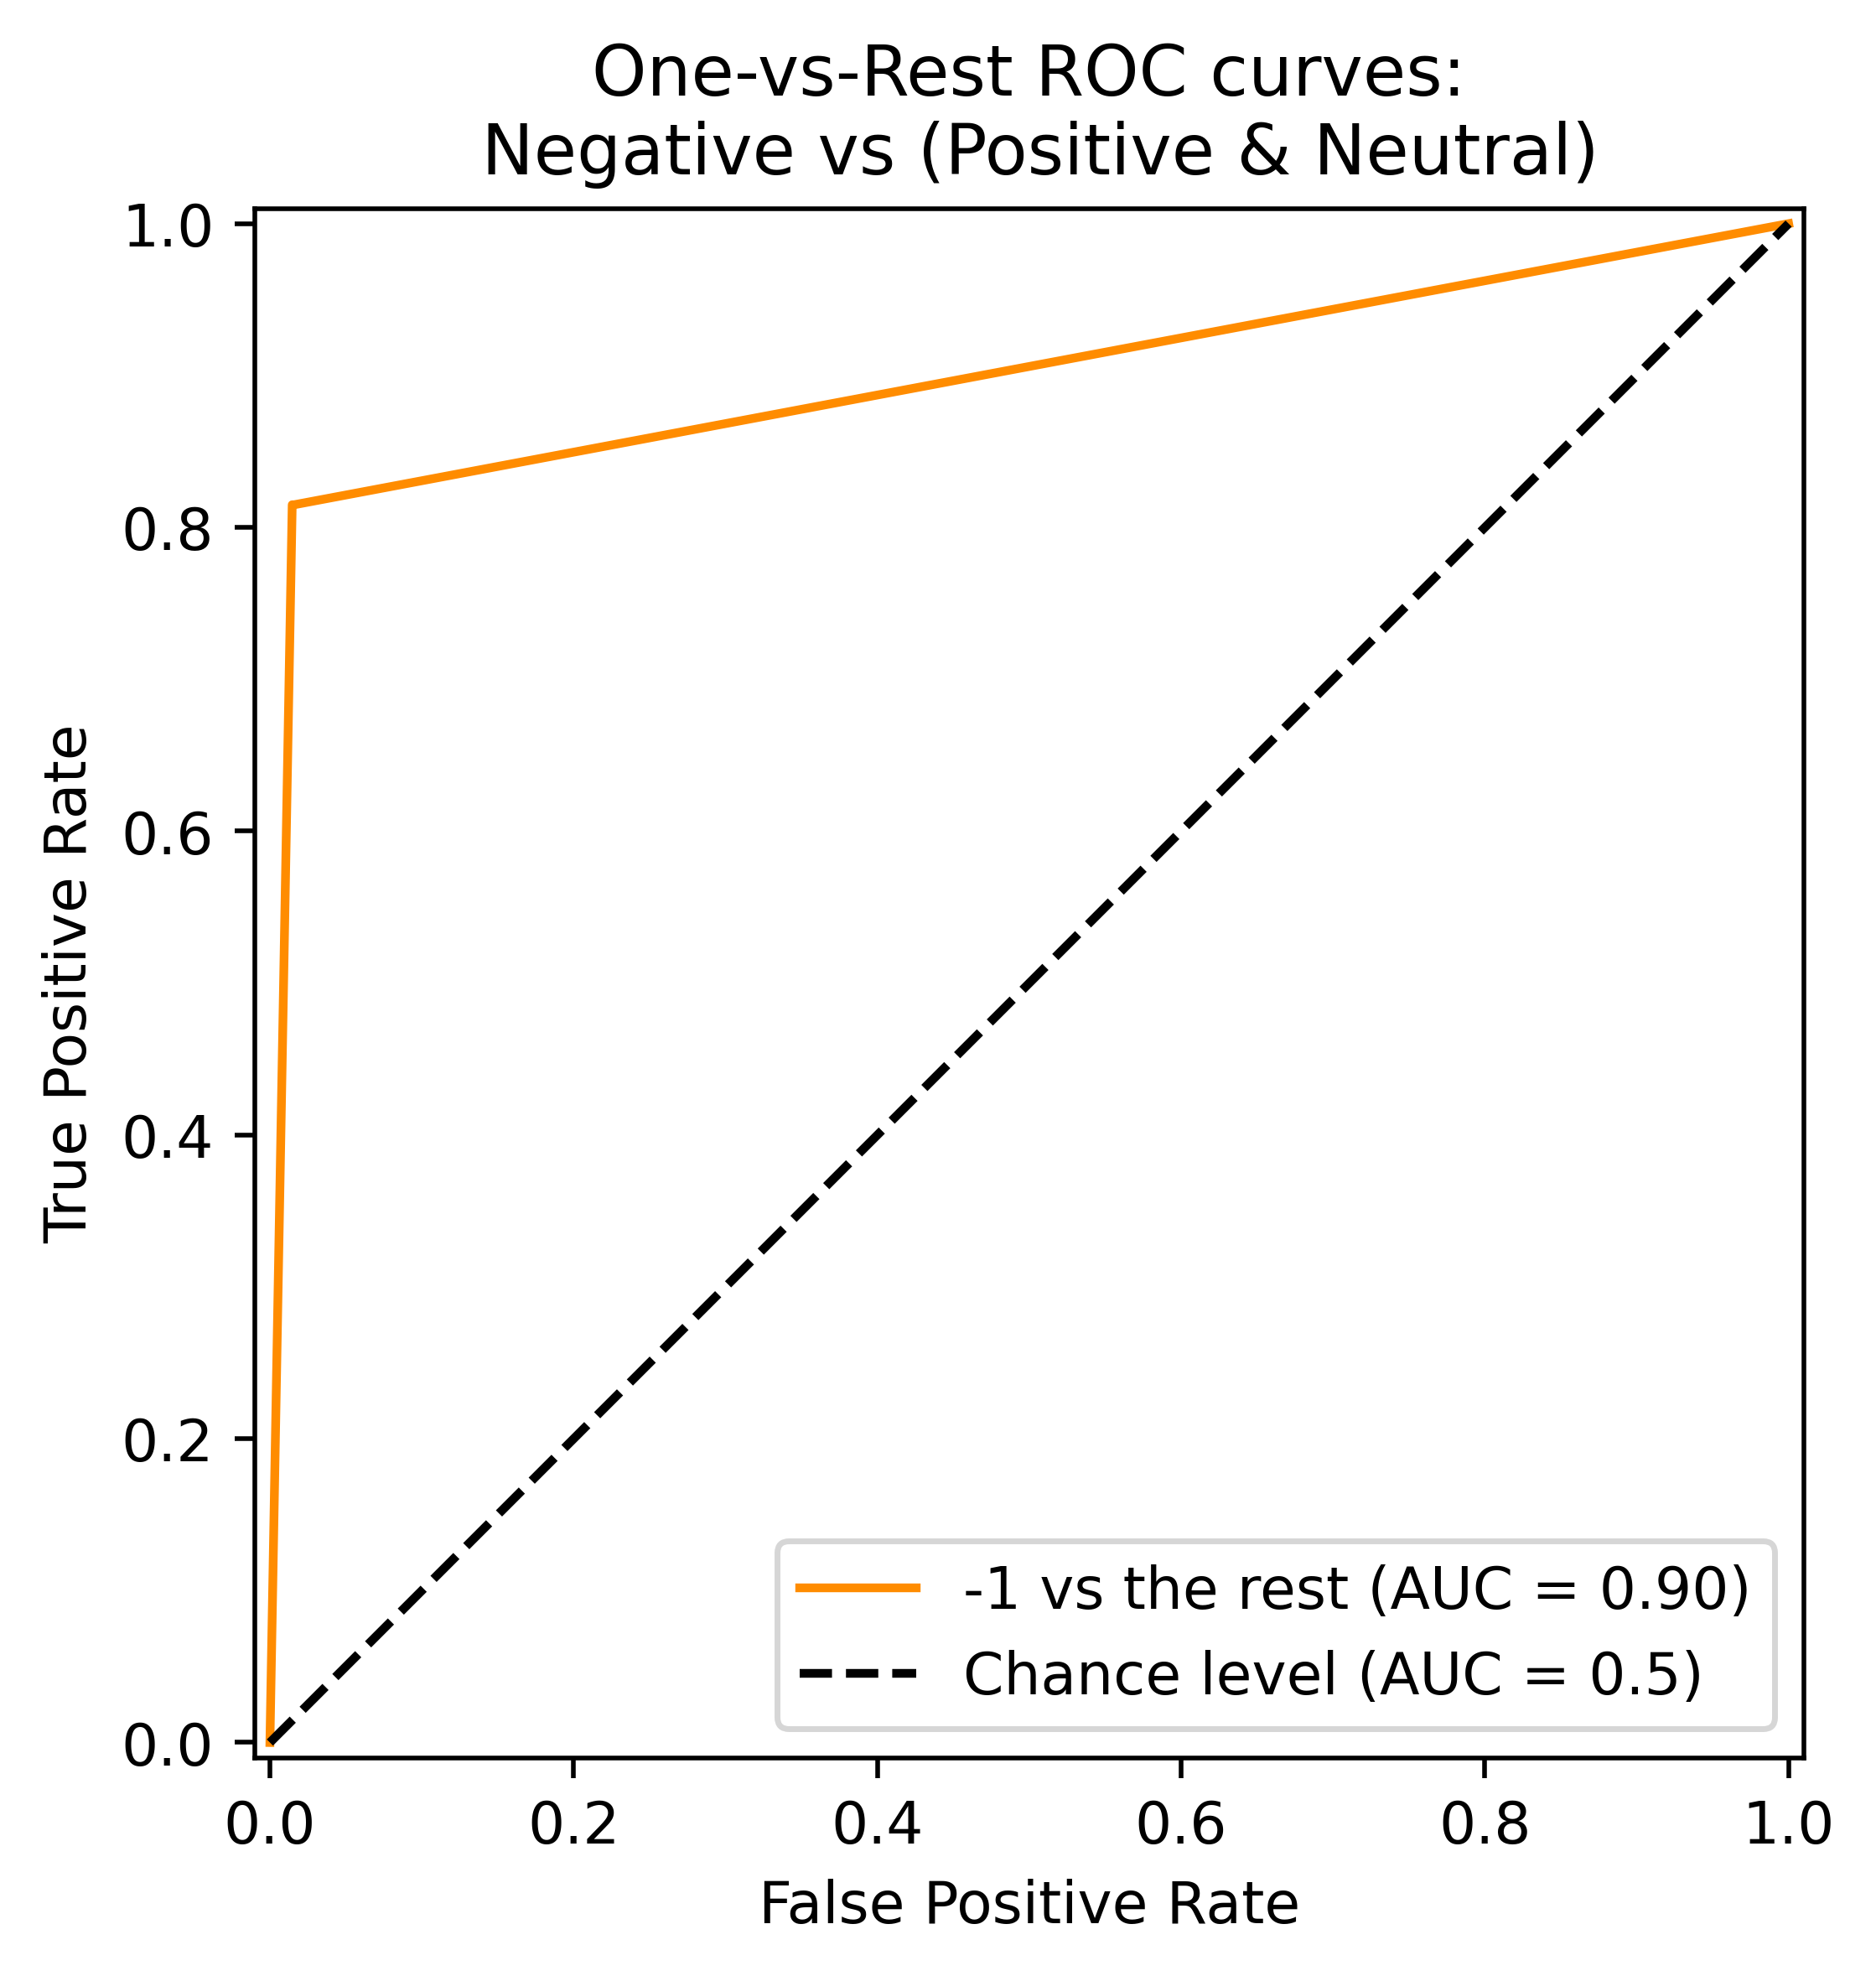

In [62]:
# for negative sentiments
# ROC curve showing an individual class
class_of_interest = -1 # negative sentiment class
class_id = np.flatnonzero(label_binarizer.classes_ == class_of_interest)[0]
display = RocCurveDisplay.from_predictions(
    y_onehot_test[:, class_id],
    y_score[:, class_id],
    name=f"{class_of_interest} vs the rest",
    color="darkorange",
    plot_chance_level=True,
)
_ = display.ax_.set(
    xlabel="False Positive Rate",
    ylabel="True Positive Rate",
    title="One-vs-Rest ROC curves:\n Negative vs (Positive & Neutral)",
)

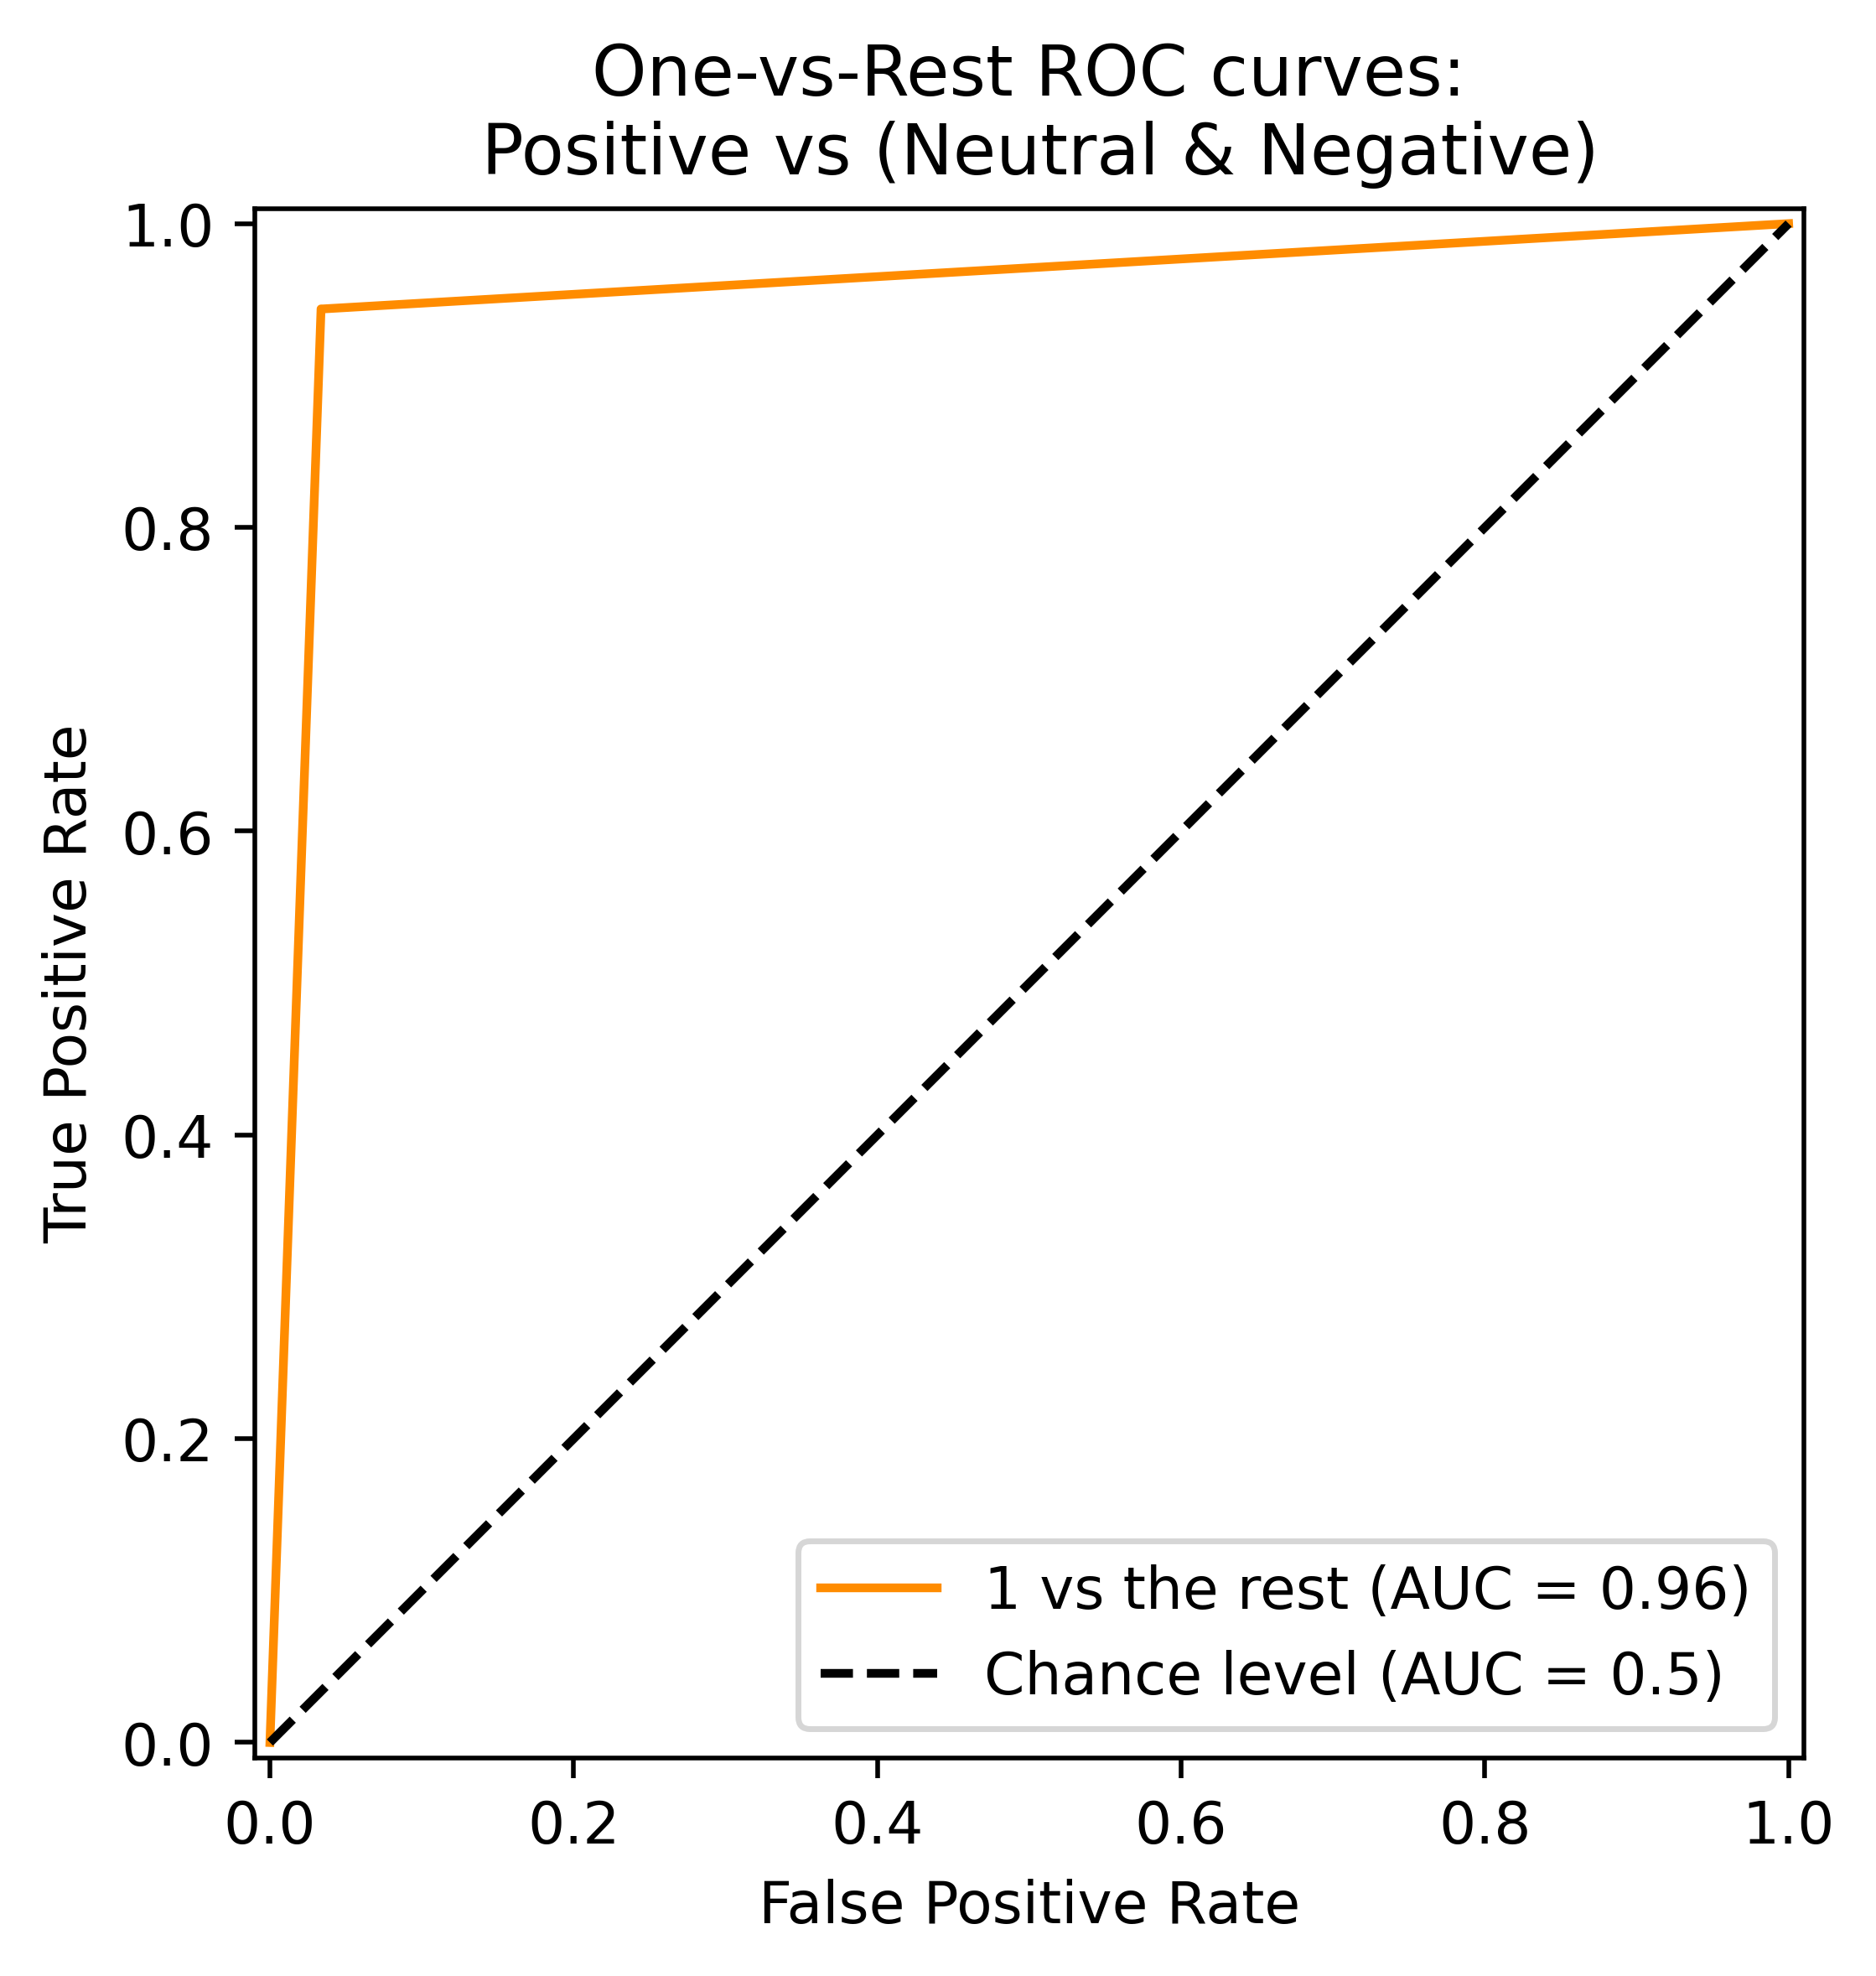

In [63]:
# for positive sentiments
# ROC curve showing an individual class
class_of_interest = 1 # negative sentiment class
class_id = np.flatnonzero(label_binarizer.classes_ == class_of_interest)[0]
display = RocCurveDisplay.from_predictions(
    y_onehot_test[:, class_id],
    y_score[:, class_id],
    name=f"{class_of_interest} vs the rest",
    color="darkorange",
    plot_chance_level=True,
)
_ = display.ax_.set(
    xlabel="False Positive Rate",
    ylabel="True Positive Rate",
    title="One-vs-Rest ROC curves:\n Positive vs (Neutral & Negative)",
)

## Roc Micro Averaged for BOW

##### Micro-averaging aggregates the contributions from all the classes (using numpy.ravel) to compute the average metrics. In a multi-class classification setup with highly imbalanced classes, micro-averaging is preferred.

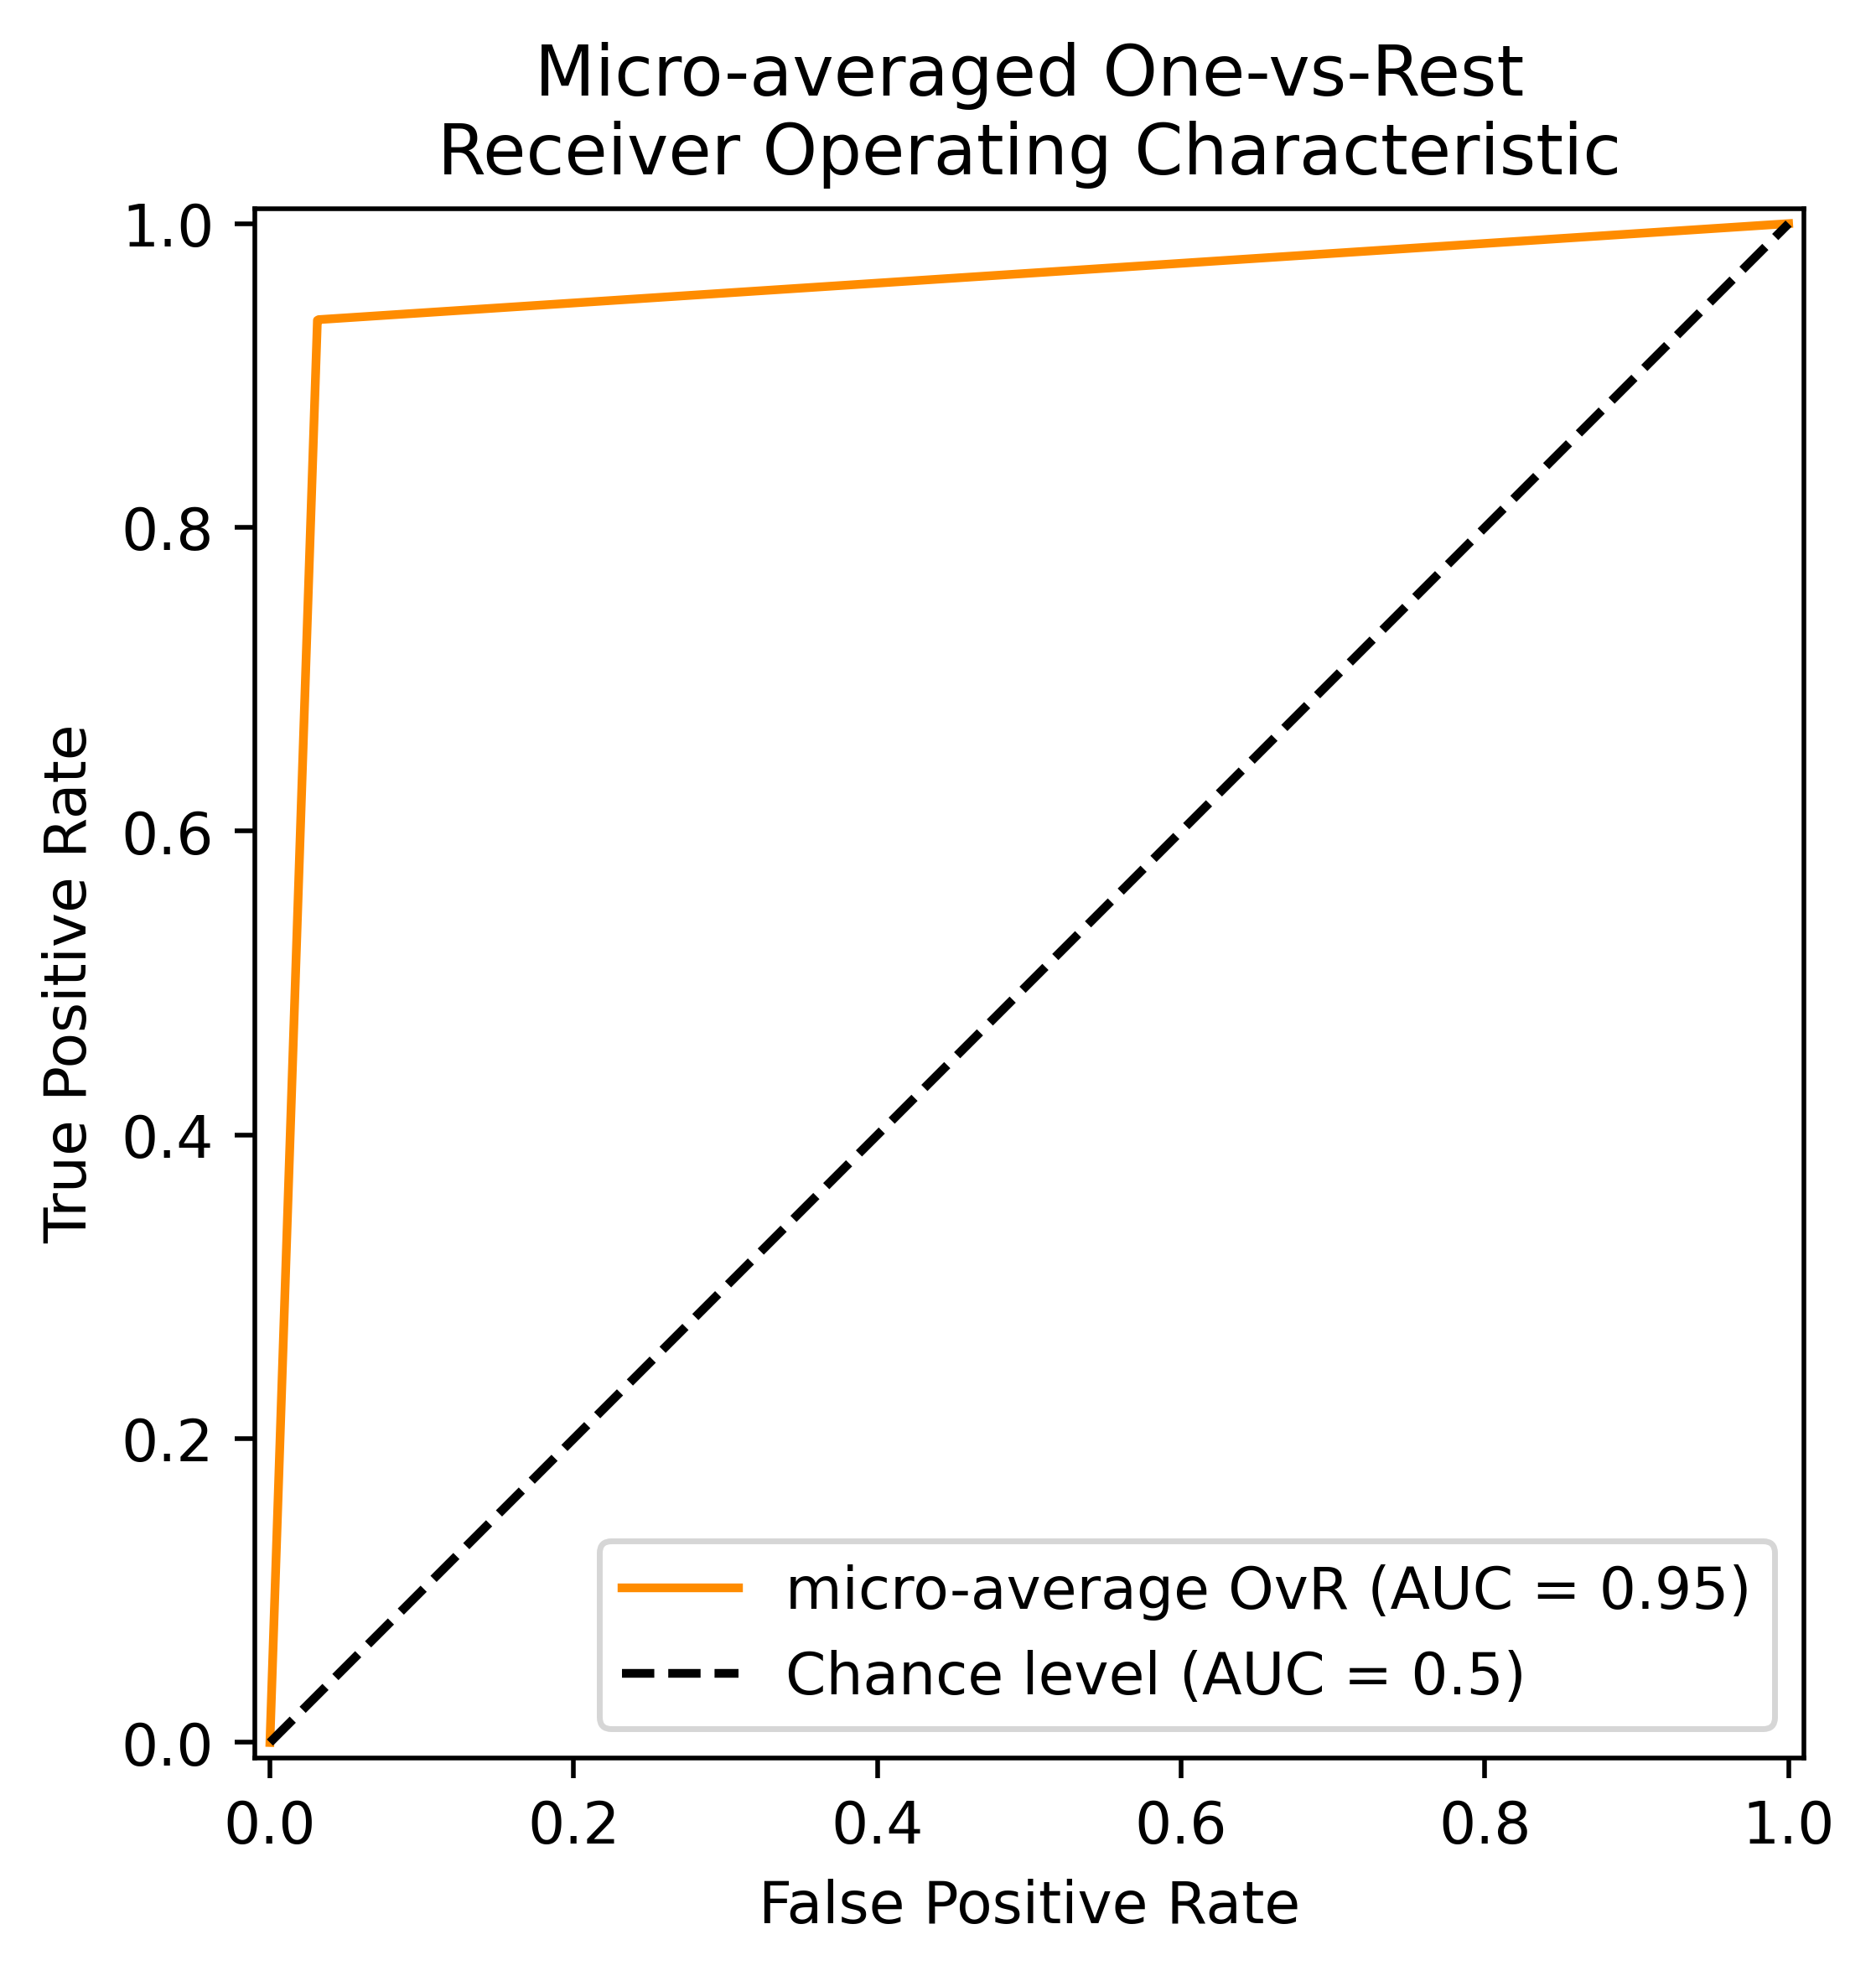

In [64]:
display = RocCurveDisplay.from_predictions(
    y_onehot_test.ravel(),
    y_score.ravel(),
    name="micro-average OvR",
    color="darkorange",
    plot_chance_level=True,
)
_ = display.ax_.set(
    xlabel="False Positive Rate",
    ylabel="True Positive Rate",
    title="Micro-averaged One-vs-Rest\nReceiver Operating Characteristic",
)

In [65]:
# computing ROC-AUC score
micro_roc_auc_ovr = roc_auc_score(
    y_test,
    y_score,
    multi_class="ovr",
    average="micro",
)
print(f"Micro-averaged One-vs-Rest ROC AUC score:\n{micro_roc_auc_ovr}")

Micro-averaged One-vs-Rest ROC AUC score:
0.9527331172188078


# Repeated K-Fold Cross Validation

In [4]:

# Creating TF-IDF vectorizer for text
tfidf_vectorizer_text = TfidfVectorizer(stop_words=stop_words_appened, max_features=1000)
X_tfidf_text = tfidf_vectorizer_text.fit_transform(X['text'])

# Creating TF-IDF vectorizer for base_url
tfidf_vectorizer_url = TfidfVectorizer(stop_words=stop_words_appened, max_features=1000)
X_tfidf_url = tfidf_vectorizer_url.fit_transform(X['base_url'])

# Creating TF-IDF vectorizer for company_names
tfidf_vectorizer_company = TfidfVectorizer(stop_words=stop_words_appened, max_features=1000)
X_tfidf_company = tfidf_vectorizer_company.fit_transform(X['company_names'])

# Concatenating the TF-IDF matrices horizontally
X_tfidf_combined = hstack([X_tfidf_text, X_tfidf_url, X_tfidf_company])

In [5]:
# Creating BoW vectorizer for text
bow_vectorizer_text = CountVectorizer(max_features=1000)
X_bow_text = bow_vectorizer_text.fit_transform(X['text'])

bow_vectorizer_url = CountVectorizer(max_features=1000)
X_bow_url = bow_vectorizer_url.fit_transform(X['base_url'])

bow_vectorizer_company = CountVectorizer(max_features=1000)
X_bow_company = bow_vectorizer_company.fit_transform(X['company_names'])

X_bow_combined = hstack([X_bow_text, X_bow_url, X_bow_company])

In [6]:
def evaluate_model(features, target, num_repeats):
    # Define the model
    model = tree.DecisionTreeClassifier()
    # Prepare the cross-validation procedure
    cv = RepeatedKFold(n_splits=10, n_repeats=num_repeats, random_state=1)
    # Evaluate the model
    scores = cross_val_score(model, features, target, scoring='accuracy', cv=cv, n_jobs=-1)

    return scores

In [7]:
# Evaluation parameters
repeats = range(1, 10)  # Number of repeats for cross-validation

Cross-Validation Repeats: 1, Mean Accuracy: 0.9346, SEM: 0.001
Cross-Validation Repeats: 2, Mean Accuracy: 0.9328, SEM: 0.001
Cross-Validation Repeats: 3, Mean Accuracy: 0.9330, SEM: 0.001
Cross-Validation Repeats: 4, Mean Accuracy: 0.9329, SEM: 0.001
Cross-Validation Repeats: 5, Mean Accuracy: 0.9325, SEM: 0.001
Cross-Validation Repeats: 6, Mean Accuracy: 0.9327, SEM: 0.001
Cross-Validation Repeats: 7, Mean Accuracy: 0.9328, SEM: 0.001
Cross-Validation Repeats: 8, Mean Accuracy: 0.9324, SEM: 0.001
Cross-Validation Repeats: 9, Mean Accuracy: 0.9325, SEM: 0.001


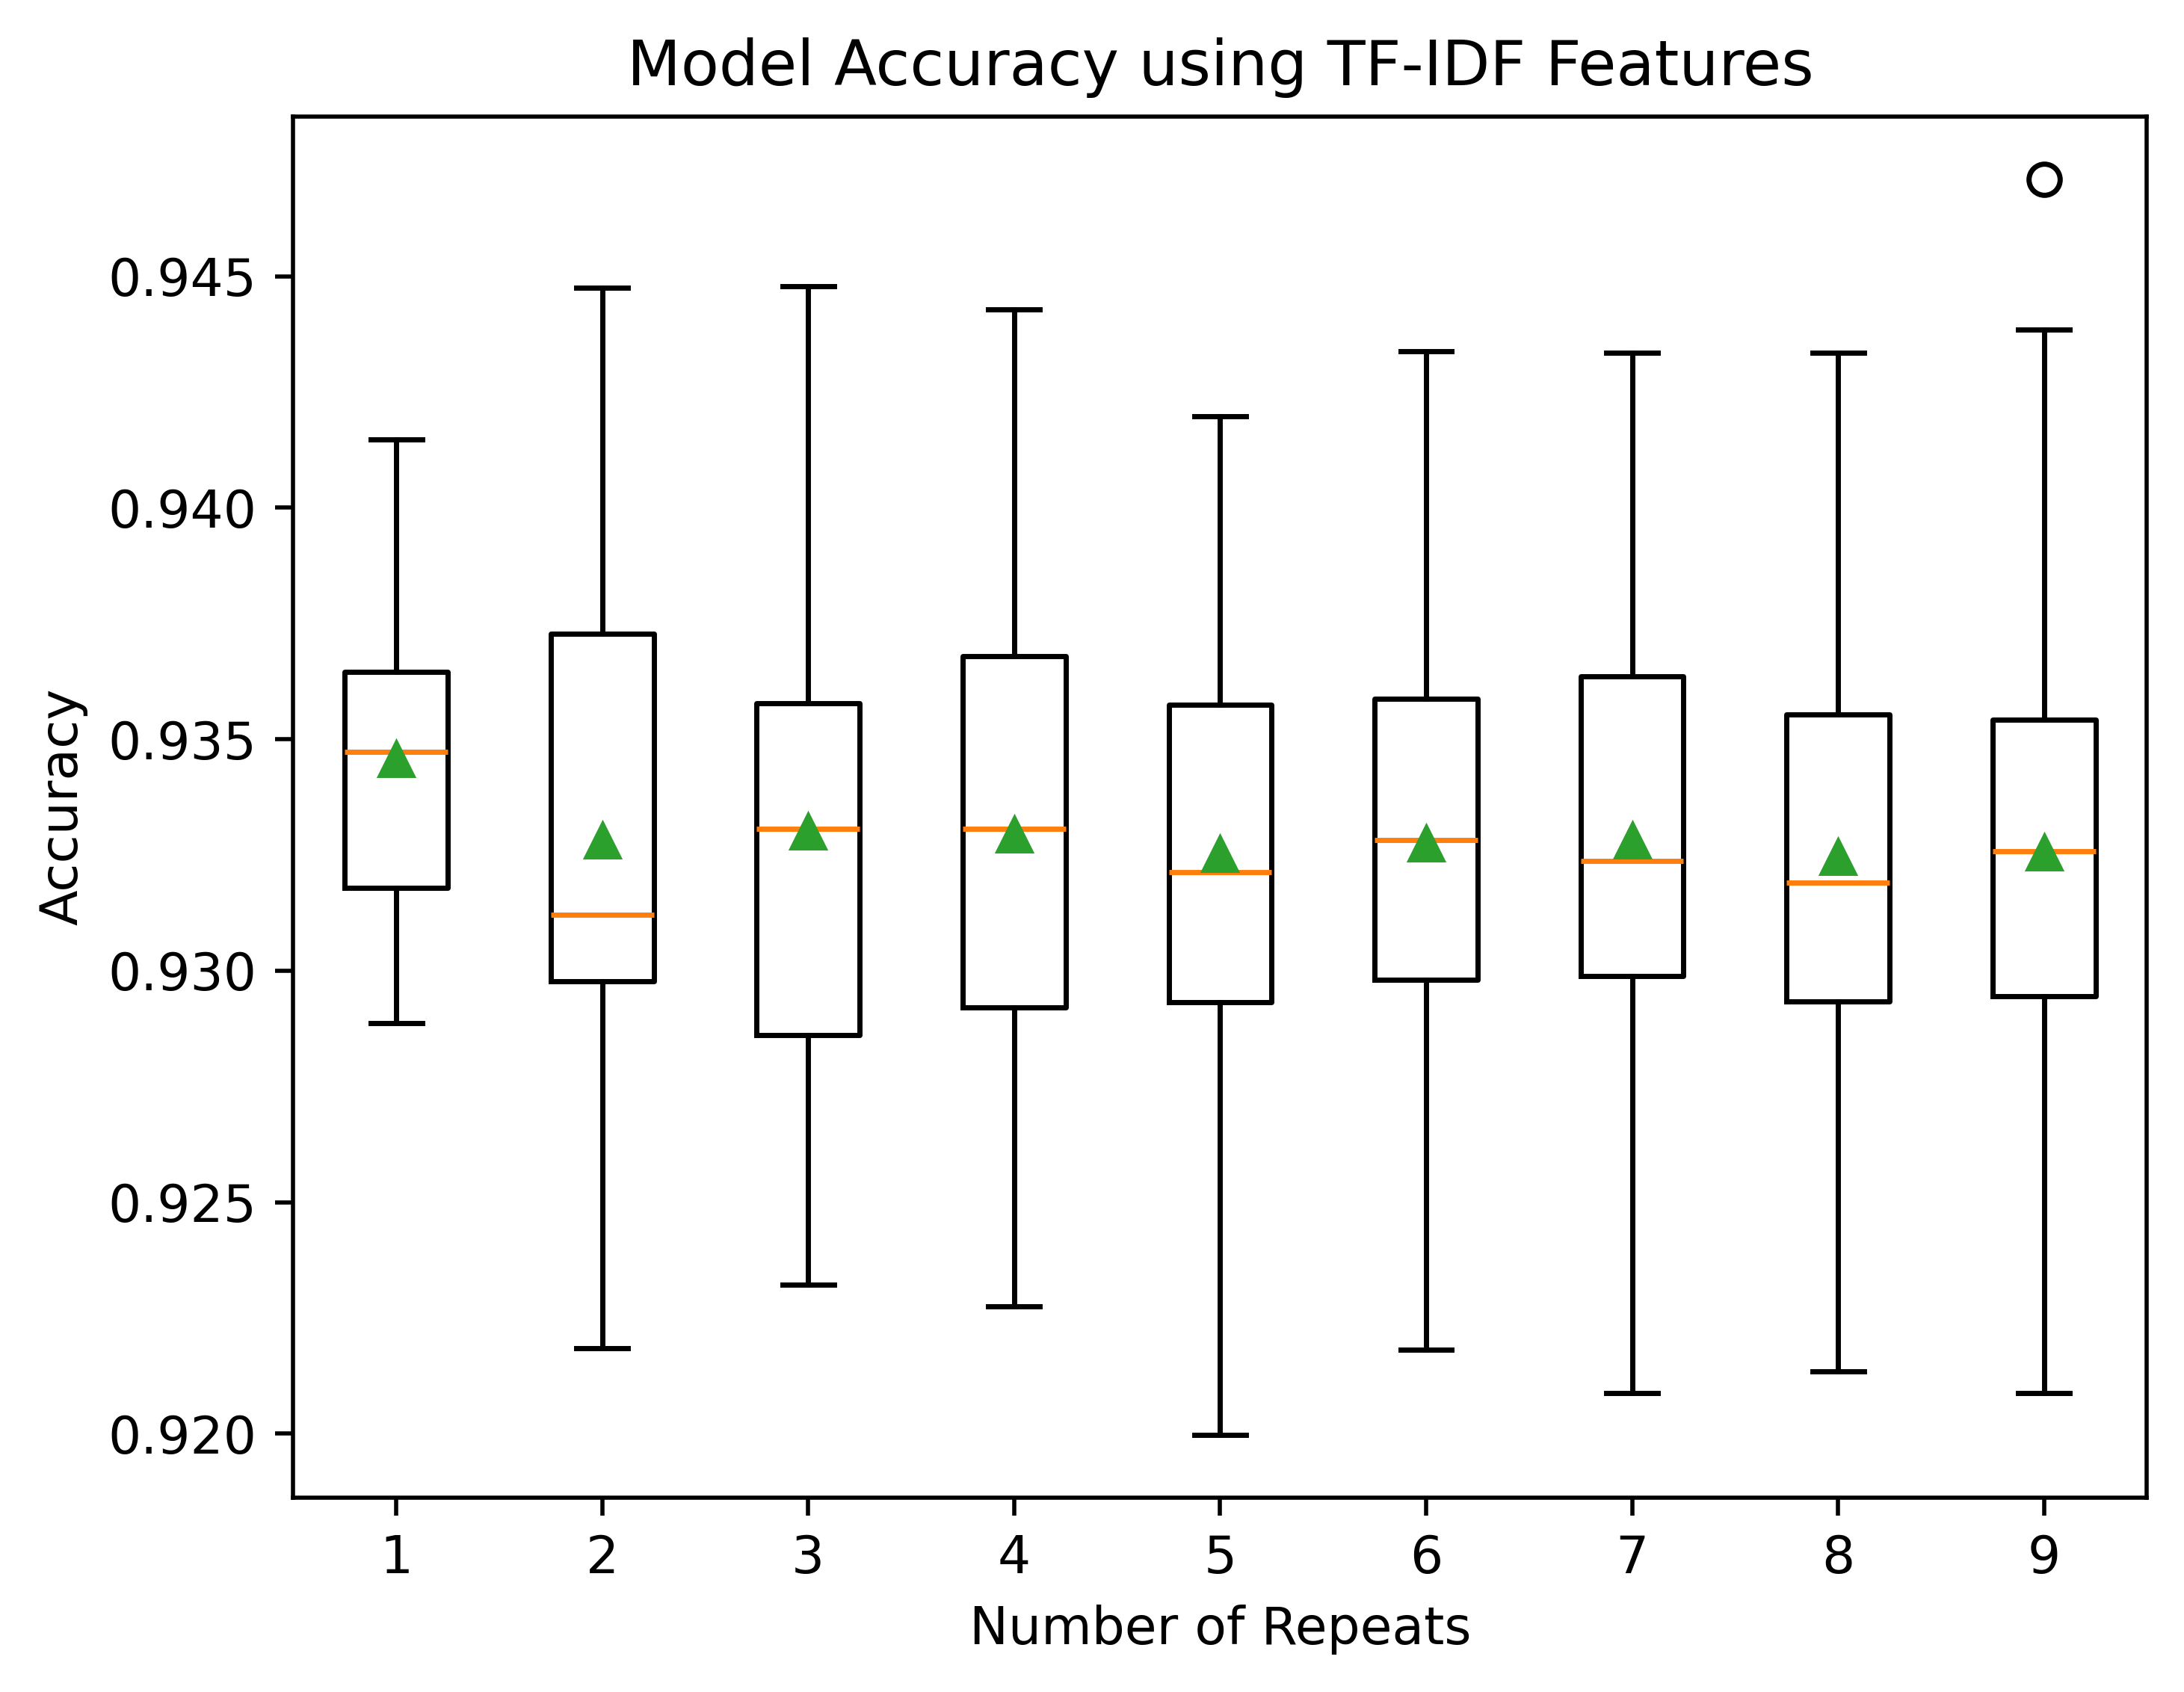

In [8]:
results_tfidf = []  # List to store the results of each evaluation

# Evaluate the model using TF-IDF combined features
for r in repeats:
    # Evaluate the model using a specific number of repeats
    scores = evaluate_model(X_tfidf_combined, Y, r)
    # Summarize and print the mean accuracy, SEM, and OOB score
    print(f'Cross-Validation Repeats: {r}, Mean Accuracy: {np.mean(scores):.4f}, SEM: {sem(scores):.3f}')
    # Store the results
    results_tfidf.append(scores)

# Plot the results of the evaluations
plt.boxplot(results_tfidf, labels=[str(r) for r in repeats], showmeans=True)
plt.title('Model Accuracy using TF-IDF Features')
plt.ylabel('Accuracy')
plt.xlabel('Number of Repeats')
plt.show()

# Save results
model = "dt_tfidf"
results = pd.DataFrame(results_tfidf)
results.to_csv(f'k-fold_results/1/{model}.csv', index=False)

Cross-Validation Repeats: 1, Mean Accuracy: 0.9416, SEM: 0.001
Cross-Validation Repeats: 2, Mean Accuracy: 0.9415, SEM: 0.001
Cross-Validation Repeats: 3, Mean Accuracy: 0.9417, SEM: 0.001
Cross-Validation Repeats: 4, Mean Accuracy: 0.9416, SEM: 0.001
Cross-Validation Repeats: 5, Mean Accuracy: 0.9412, SEM: 0.001
Cross-Validation Repeats: 6, Mean Accuracy: 0.9407, SEM: 0.001
Cross-Validation Repeats: 7, Mean Accuracy: 0.9409, SEM: 0.001
Cross-Validation Repeats: 8, Mean Accuracy: 0.9412, SEM: 0.001
Cross-Validation Repeats: 9, Mean Accuracy: 0.9412, SEM: 0.000


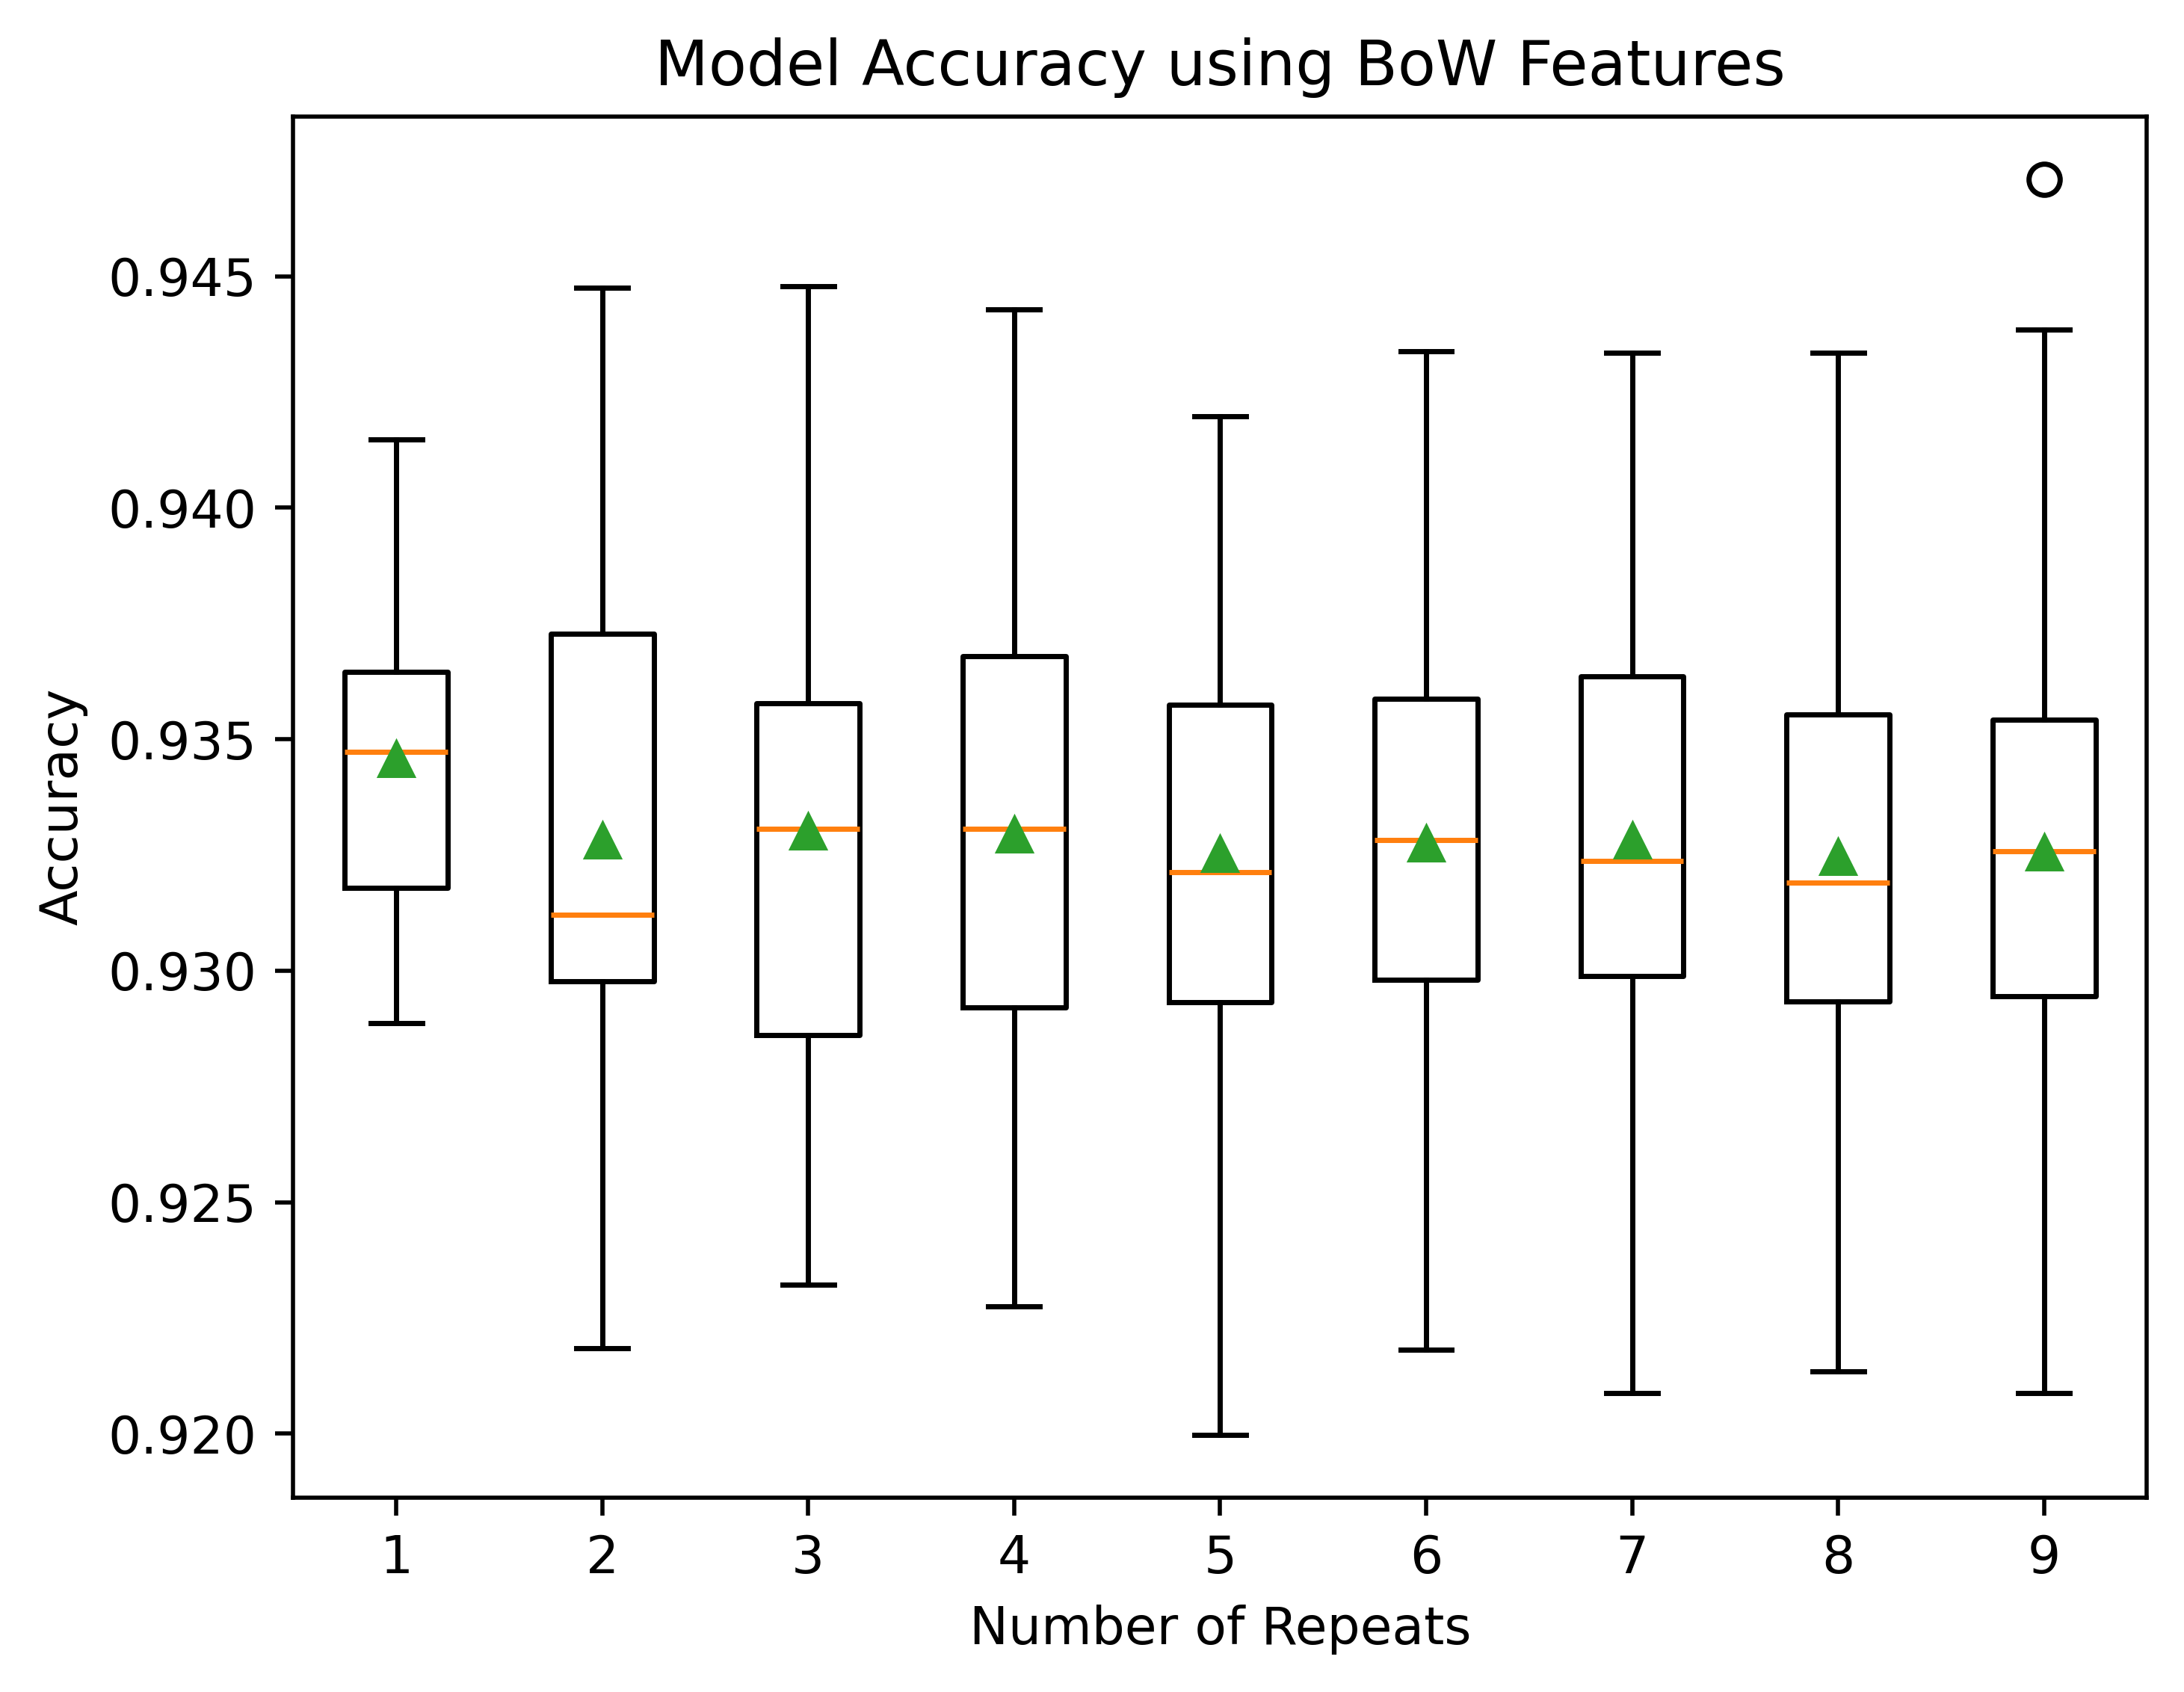

In [9]:
results_bow = []  # List to store the results of each evaluation

# Evaluate the model using TF-IDF combined features
for r in repeats:
    # Evaluate the model using a specific number of repeats
    scores = evaluate_model(X_bow_combined, Y, r)
    # Summarize and print the mean accuracy, SEM, and OOB score
    print(f'Cross-Validation Repeats: {r}, Mean Accuracy: {np.mean(scores):.4f}, SEM: {sem(scores):.3f}')
    # Store the results
    results_bow.append(scores)

# Plot the results of the evaluations
plt.boxplot(results_tfidf, labels=[str(r) for r in repeats], showmeans=True)
plt.title('Model Accuracy using BoW Features')
plt.ylabel('Accuracy')
plt.xlabel('Number of Repeats')
plt.show()

# Save results
model = "dt_bow"
results = pd.DataFrame(results_bow)
results.to_csv(f'k-fold_results/1/{model}.csv', index=False)

## Hyper parameter tunning of Decision Trees

## Grid Search

In [85]:
from sklearn.model_selection import GridSearchCV

In [86]:
tree_gdcv = tree.DecisionTreeClassifier(random_state=43)

params = {'max_depth':[15,30,60,90],
          'min_samples_leaf':[2,3,5,10,15],
          'min_samples_split':[3,5,8,10,12],
          'criterion':['gini','entropy']}
GS = GridSearchCV(estimator=tree_gdcv,param_grid=params,cv=10,n_jobs=-1, verbose=True, scoring='accuracy')

In [87]:
GS.fit(X_bow_combined, Y)

Fitting 10 folds for each of 200 candidates, totalling 2000 fits


GridSearchCV(cv=10, estimator=DecisionTreeClassifier(random_state=43),
             n_jobs=-1,
             param_grid={'criterion': ['gini', 'entropy'],
                         'max_depth': [15, 30, 60, 90],
                         'min_samples_leaf': [2, 3, 5, 10, 15],
                         'min_samples_split': [3, 5, 8, 10, 12]},
             scoring='accuracy', verbose=True)

In [88]:
print('Best Parameters:',GS.best_params_,end='\n\n')
print('Best Score:',GS.best_score_)

Best Parameters: {'criterion': 'gini', 'max_depth': 60, 'min_samples_leaf': 3, 'min_samples_split': 12}

Best Score: 0.9319898734443433


## RandomizedSearch CV

In [89]:
from sklearn.model_selection import RandomizedSearchCV

In [90]:
tree_RS = tree.DecisionTreeClassifier(random_state=43)

params = {'max_depth':[3,5,7,10,15,30, 60, 120],
          'min_samples_leaf':[3,5,10,15,20],
          'min_samples_split':[8,10,12,18,20,16],
          'criterion':['gini','entropy']}
RS = RandomizedSearchCV(estimator=tree_RS,param_distributions=params,cv=10,n_iter=300,n_jobs=-1, verbose=True, scoring='accuracy')

In [91]:
RS.fit(X_bow_combined, Y)

Fitting 10 folds for each of 300 candidates, totalling 3000 fits


RandomizedSearchCV(cv=10, estimator=DecisionTreeClassifier(random_state=43),
                   n_iter=300, n_jobs=-1,
                   param_distributions={'criterion': ['gini', 'entropy'],
                                        'max_depth': [3, 5, 7, 10, 15, 30, 60,
                                                      120],
                                        'min_samples_leaf': [3, 5, 10, 15, 20],
                                        'min_samples_split': [8, 10, 12, 18, 20,
                                                              16]},
                   scoring='accuracy', verbose=True)

In [92]:
print('Best Parameters:',RS.best_params_,end='\n\n')
print('Best Score:',RS.best_score_)

Best Parameters: {'min_samples_split': 12, 'min_samples_leaf': 3, 'max_depth': 60, 'criterion': 'gini'}

Best Score: 0.9319898734443433
